In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
from cartopy.util import add_cyclic_point

# import regionmask

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

# Import Ngl with pyn_env active 
# import Ngl

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



## Read in data (slightly more organized)

In [2]:
def combineFields(saveDir, caseStart, maxYr): 
    fileEnds_h1 = ['_1dVars.nc','_lowLevelUV.nc','_lowLevelT.nc']
    fileEnds_h0 = ['_tau.nc']


    for iEnd in range(len(fileEnds_h1)):

        ## Daily data 
        listFiles = np.sort(glob.glob(saveDir+caseStart+'*h1*'+fileEnds_h1[iEnd]))
        if len(listFiles)>1:
            print('WARNING: more than one matching file found; using first file in list') 
            print(listFiles)

        ds = xr.open_dataset(listFiles[0], decode_times=True)

        iYrs = np.where(ds['time.year'] <= maxYr)[0]
        ds   = ds.isel(time=iYrs) 

        if iEnd==0:
            caseDS_h1 = ds 
        else: 
            caseDS_h1 = xr.merge([caseDS_h1, ds]) 

    for iEnd in range(len(fileEnds_h0)):
        ## Monthly data 
        listFiles = np.sort(glob.glob(saveDir+caseStart+'*h0*'+fileEnds_h0[iEnd]))
        if len(listFiles)>1:
            print('WARNING: more than one matching file found; using first file in list') 
            print(listFiles)

        ds = xr.open_dataset(listFiles[0], decode_times=True)

        iYrs = np.where(ds['time.year'] < maxYr)[0]
        ds   = ds.isel(time=iYrs) 

        if iEnd==0:
            caseDS_h0 = ds 
        else: 
            caseDS_h0 = xr.merge([caseDS_h0, ds]) 
            
    return caseDS_h1, caseDS_h0 

### Side bar: plot height of levels

In [31]:
L32file  = '/glade/scratch/mdfowler/archive/F2010climo.f09_f09_mg17.TestGustGlobal_Control.001/atm/hist/F2010climo.f09_f09_mg17.TestGustGlobal_Control.001.cam.h0.0004-06.nc'
L32_z3   = xr.open_dataset(L32file, decode_times = True)['Z3'] 
L32_z3_point = np.squeeze(L32_z3.isel(lat=120, lon=120))


L58file  = '/glade/scratch/mdfowler/archive/F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.002/atm/hist/F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.002.cam.h0.0004-06.nc'
L58_z3   = xr.open_dataset(L58file, decode_times = True)['Z3'] 
L58_z3_point = np.squeeze(L58_z3.isel(lat=120, lon=120))

L48file  = '/glade/scratch/mdfowler/archive/F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_48L.002/atm/hist/F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_48L.002.cam.h0.0004-06.nc'
L48_z3   = xr.open_dataset(L48file, decode_times = True)['Z3'] 
L48_z3_point = np.squeeze(L48_z3.isel(lat=120, lon=120))

print(L32_z3_point.units)

m


In [8]:
L32_z3_point

<xarray.DataArray 'Z3' (lev: 32)>
array([38263.355   , 33000.664   , 28680.266   , 25253.064   , 22944.416   ,
       21538.314   , 20446.361   , 19401.275   , 18334.8     , 17318.71    ,
       16383.656   , 15446.206   , 14493.677   , 13512.876   , 12486.011   ,
       11410.745   , 10293.861   ,  9134.8545  ,  7934.796   ,  6695.669   ,
        5419.2197  ,  4206.018   ,  3168.7485  ,  2335.415   ,  1717.7971  ,
        1323.0309  ,  1051.653   ,   804.5628  ,   582.0855  ,   384.60965 ,
         212.5045  ,    66.354454], dtype=float32)
Coordinates:
    lat      float64 23.09
    lon      float64 150.0
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
    time     object 0004-07-01 00:00:00
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean

In [9]:
L58_z3_point

<xarray.DataArray 'Z3' (lev: 58)>
array([3.960819e+04, 3.527754e+04, 3.172970e+04, 2.870912e+04, 2.615876e+04,
       2.403206e+04, 2.227909e+04, 2.084222e+04, 1.966241e+04, 1.868735e+04,
       1.786858e+04, 1.716124e+04, 1.653283e+04, 1.596202e+04, 1.543075e+04,
       1.492584e+04, 1.443776e+04, 1.395969e+04, 1.348665e+04, 1.301494e+04,
       1.254185e+04, 1.206541e+04, 1.158425e+04, 1.109864e+04, 1.060869e+04,
       1.011196e+04, 9.606908e+03, 9.093777e+03, 8.572659e+03, 8.043673e+03,
       7.506977e+03, 6.962740e+03, 6.411090e+03, 5.851986e+03, 5.285172e+03,
       4.721835e+03, 4.191932e+03, 3.718232e+03, 3.300010e+03, 2.928463e+03,
       2.596652e+03, 2.299197e+03, 2.031936e+03, 1.791312e+03, 1.574112e+03,
       1.377509e+03, 1.199053e+03, 1.036703e+03, 8.887381e+02, 7.536879e+02,
       6.302745e+02, 5.173802e+02, 4.140204e+02, 3.193203e+02, 2.324969e+02,
       1.528460e+02, 7.973236e+01, 2.236726e+01], dtype=float32)
Coordinates:
    lat      float64 23.09
    lon      float64 150.0
  * lev      (lev) float64 3.018 5.445 9.087 14.25 ... 974.5 983.2 991.2 997.5
    time     object 0004-07-01 00:00:00
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean

In [32]:
dz_32L = []

for iLev in range(len(L32_z3_point.lev.values)):
    if iLev==len(L32_z3_point.lev.values)-1: 
        dz_32L = np.append(dz_32L, L32_z3_point.values[iLev]-0)
    else: 
        dz_32L = np.append(dz_32L, L32_z3_point.values[iLev]-L32_z3_point.values[iLev+1])

        
dz_58L = []
for iLev in range(len(L58_z3_point.lev.values)):
    if iLev==len(L58_z3_point.lev.values)-1: 
        dz_58L = np.append(dz_58L, L58_z3_point.values[iLev]-0)
    else: 
        dz_58L = np.append(dz_58L, L58_z3_point.values[iLev]-L58_z3_point.values[iLev+1])
        

dz_48L = []
for iLev in range(len(L48_z3_point.lev.values)):
    if iLev==len(L48_z3_point.lev.values)-1: 
        dz_48L = np.append(dz_48L, L48_z3_point.values[iLev]-0)
    else: 
        dz_48L = np.append(dz_48L, L48_z3_point.values[iLev]-L48_z3_point.values[iLev+1])
        
        

In [84]:
print(L48_z3_point.values[-1])

67.540924


Text(0.5, 1.0, 'Level midpoints')

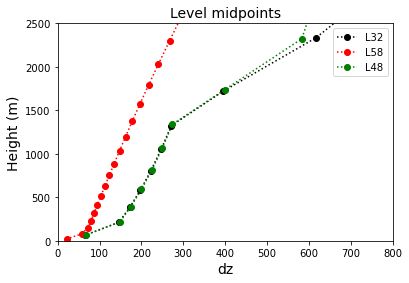

In [42]:
plt.plot(dz_32L, np.squeeze(L32_z3_point.values),'k:o',label='L32')
plt.plot(dz_58L, np.squeeze(L58_z3_point.values),'r:o',label='L58')
plt.plot(dz_48L, np.squeeze(L48_z3_point.values),'g:o',label='L48')
plt.ylim([0,2500])
plt.xlim([0,800])

plt.ylabel('Height (m)', fontsize=14)
plt.xlabel('dz',fontsize=14)
plt.legend()
plt.title('Level midpoints',fontsize=14)

Text(0.5, 1.0, 'Level midpoints')

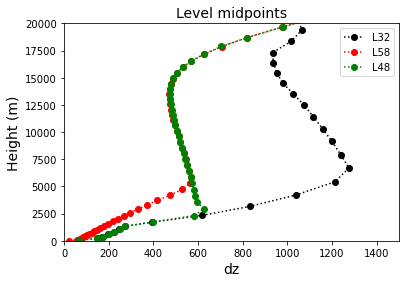

In [38]:
plt.plot(dz_32L, np.squeeze(L32_z3_point.values),'k:o',label='L32')
plt.plot(dz_58L, np.squeeze(L58_z3_point.values),'r:o',label='L58')
plt.plot(dz_48L, np.squeeze(L48_z3_point.values),'g:o',label='L48')
plt.ylim([0,20000])
plt.xlim([0,1500])

plt.ylabel('Height (m)', fontsize=14)
plt.xlabel('dz',fontsize=14)
plt.legend()
plt.title('Level midpoints',fontsize=14)

## Continue on: read in data

In [24]:
maxYr = 4 
 
saveDir = '/glade/work/mdfowler/gust_cam7/output/'
saveDirFV = '/glade/p/cgd/amp/mdfowler/Gust/'

L32fv_cam6_h1,   L32fv_cam6_h0   = combineFields(saveDir, 'F2010climo.f09_f09_mg17.TestGustGlobal_Control.001', maxYr)
L58se_camdev_h1, L58se_camdev_h0 = combineFields(saveDir, 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.002', maxYr)
L58fv_cam6_h1,   L58fv_cam6_h0   = combineFields(saveDirFV,'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L.001', maxYr)
L58se_cam6_h1,   L58se_cam6_h0   = combineFields(saveDir,'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L_cam6phys.001', maxYr)
L58se_cam6mod_h1,    L58se_cam6mod_h0    = combineFields(saveDir,'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L_cam6phys_StableConstantEq7', maxYr)
L58se_camdevMove_h1, L58se_camdevMove_h0 = combineFields(saveDir,'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.MoveWriteHist.001', maxYr)
L48se_camdev_h1, L48se_camdev_h0 = combineFields(saveDir, 'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_48L.002', maxYr)
L48se_cam6_h1,   L48se_cam6_h0   = combineFields(saveDir,'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_48L_cam6phys.001', maxYr)
L58se_camdevMoveCOARE_h1, L58se_camdevMoveCOARE_h0 = combineFields(saveDir,'F2010climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_Control_58L.MoveWriteHist_useCOARE.001', maxYr)
L58fv_adjustU10_h1,   L58fv_adjustU10_h0   = combineFields(saveDir,'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_useAdjustedU10', maxYr)

print('Done reading in & combining data') 


Done reading in & combining data


In [62]:
np.unique(L58fv_cam6_h1['time.year'].values)

array([2, 3, 4])

In [4]:
## Read in special case (ongoing) 
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_useAdjustedU10_noColdAirOutbreak.001'

scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'
L58fv_adjustU10_noCold_h1 = xr.open_dataset(scratchDir+caseName+'.cam.h2.0001_windVars.nc', decode_times=True)

print('Done with getting special case')

Done with getting special case


In [5]:
L58fv_adjustU10_noCold_h1['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_adjustU10_noCold_h1['UBOT'].values**2 + L58fv_adjustU10_noCold_h1['VBOT'].values**2) )
L58fv_adjustU10_noCold_h1['windSpeedBot'].attrs['units']   = "m/s"


L58fv_adjustU10_noCold_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_adjustU10_noCold_h1['windSpeedBot'].values - L58fv_adjustU10_noCold_h1['U10'].values)
L58fv_adjustU10_noCold_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"



In [6]:
## Read in new case that doesn't iterate over U10 (still u10n) but outputs it 
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_outputAdjustedU10.003'

scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'
L58fv_outAdjustU10_noCold_h1 = xr.open_dataset(scratchDir+caseName+'.cam.h2.001_windVars.nc', decode_times=True)

print('Done with getting special case')

L58fv_outAdjustU10_noCold_h1['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_outAdjustU10_noCold_h1['UBOT'].values**2 + L58fv_outAdjustU10_noCold_h1['VBOT'].values**2) )
L58fv_outAdjustU10_noCold_h1['windSpeedBot'].attrs['units']   = "m/s"


L58fv_outAdjustU10_noCold_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_outAdjustU10_noCold_h1['windSpeedBot'].values - L58fv_outAdjustU10_noCold_h1['U10'].values)
L58fv_outAdjustU10_noCold_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


In [7]:
## Read in new control case (instant output, no cold air outbreak)
caseName   = 'F2010climo.f09_f09_mg17.TestGustGlobal_Control_58L_noColdAir_instOutput.001'

scratchDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'
L58fv_ctrlInst_noCold_h1 = xr.open_dataset(scratchDir+caseName+'.cam.h2.001_windVars.nc', decode_times=True)

print('Done with getting special case')

L58fv_ctrlInst_noCold_h1['windSpeedBot'] = (('time','lat','lon'),    
                                np.sqrt(L58fv_ctrlInst_noCold_h1['UBOT'].values**2 + L58fv_ctrlInst_noCold_h1['VBOT'].values**2) )
L58fv_ctrlInst_noCold_h1['windSpeedBot'].attrs['units']   = "m/s"


L58fv_ctrlInst_noCold_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    
                                                    L58fv_ctrlInst_noCold_h1['windSpeedBot'].values - L58fv_ctrlInst_noCold_h1['U10'].values)
L58fv_ctrlInst_noCold_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"



Done with getting special case


In [8]:
np.nanmin(L58fv_ctrlInst_noCold_h1['windSpeedBot_minU10'] - L58fv_outAdjustU10_noCold_h1['windSpeedBot_minU10'])

-1.0910234

In [25]:
## Add total wind speeds to DS 
L32fv_cam6_h1['windSpeed']   = (('time','lev','lat','lon'), np.sqrt((L32fv_cam6_h1.U.values**2)+(L32fv_cam6_h1.V.values**2)) )
L58se_camdev_h1['windSpeed'] = (('time','lev','lat','lon'), np.sqrt((L58se_camdev_h1.U.values**2)+(L58se_camdev_h1.V.values**2)) )
L58fv_cam6_h1['windSpeed']   = (('time','lev','lat','lon'), np.sqrt((L58fv_cam6_h1.U.values**2)+(L58fv_cam6_h1.V.values**2)) )
L58se_cam6_h1['windSpeed']   = (('time','lev','lat','lon'), np.sqrt((L58se_cam6_h1.U.values**2)+(L58se_cam6_h1.V.values**2)) )
L58se_cam6mod_h1['windSpeed']   = (('time','lev','lat','lon'), np.sqrt((L58se_cam6mod_h1.U.values**2)+(L58se_cam6mod_h1.V.values**2)) )
L58se_camdevMove_h1['windSpeed'] = (('time','lev','lat','lon'), np.sqrt((L58se_camdevMove_h1.U.values**2)+(L58se_camdevMove_h1.V.values**2)) )
L48se_camdev_h1['windSpeed'] = (('time','lev','lat','lon'), np.sqrt((L48se_camdev_h1.U.values**2)+(L48se_camdev_h1.V.values**2)) )
L48se_cam6_h1['windSpeed'] = (('time','lev','lat','lon'),   np.sqrt((L48se_cam6_h1.U.values**2)+(L48se_cam6_h1.V.values**2)) )
L58se_camdevMoveCOARE_h1['windSpeed'] = (('time','lev','lat','lon'), np.sqrt((L58se_camdevMoveCOARE_h1.U.values**2)+(L58se_camdevMoveCOARE_h1.V.values**2)) )
L58fv_adjustU10_h1['windSpeed'] = (('time','lev','lat','lon'), np.sqrt((L58fv_adjustU10_h1.U.values**2)+(L58fv_adjustU10_h1.V.values**2)) )
print('Done computing wind magnitudes')


Done computing wind magnitudes


In [26]:
## Add total tau to DS 
L32fv_cam6_h0['tauTotal']   = (('time','lat','lon'), np.sqrt((L32fv_cam6_h0.TAUX.values**2)+(L32fv_cam6_h0.TAUY.values**2)) )
L58se_camdev_h0['tauTotal'] = (('time','lat','lon'), np.sqrt((L58se_camdev_h0.TAUX.values**2)+(L58se_camdev_h0.TAUY.values**2)) )
L58fv_cam6_h0['tauTotal']   = (('time','lat','lon'), np.sqrt((L58fv_cam6_h0.TAUX.values**2)+(L58fv_cam6_h0.TAUY.values**2)) )
L58se_cam6_h0['tauTotal']   = (('time','lat','lon'), np.sqrt((L58se_cam6_h0.TAUX.values**2)+(L58se_cam6_h0.TAUY.values**2)) )
L58se_cam6mod_h0['tauTotal']    = (('time','lat','lon'), np.sqrt((L58se_cam6mod_h0.TAUX.values**2)+(L58se_cam6mod_h0.TAUY.values**2)) )
L58se_camdevMove_h0['tauTotal'] = (('time','lat','lon'), np.sqrt((L58se_camdevMove_h0.TAUX.values**2)+(L58se_camdevMove_h0.TAUY.values**2)) )
L48se_camdev_h0['tauTotal'] = (('time','lat','lon'), np.sqrt((L48se_camdev_h0.TAUX.values**2)+(L48se_camdev_h0.TAUY.values**2)) )
L48se_cam6_h0['tauTotal'] = (('time','lat','lon'),   np.sqrt((L48se_cam6_h0.TAUX.values**2)+(L48se_cam6_h0.TAUY.values**2)) )
L58se_camdevMoveCOARE_h0['tauTotal'] = (('time','lat','lon'), np.sqrt((L58se_camdevMoveCOARE_h0.TAUX.values**2)+(L58se_camdevMoveCOARE_h0.TAUY.values**2)) )
L58fv_adjustU10_h0['tauTotal'] = (('time','lat','lon'),   np.sqrt((L58fv_adjustU10_h0.TAUX.values**2)+(L58fv_adjustU10_h0.TAUY.values**2)) )

L32fv_cam6_h0['tauTotal'].attrs['units']   = L32fv_cam6_h0.TAUX.units
L58se_camdev_h0['tauTotal'].attrs['units'] = L32fv_cam6_h0.TAUX.units
L58fv_cam6_h0['tauTotal'].attrs['units']   = L32fv_cam6_h0.TAUX.units
L58se_cam6_h0['tauTotal'].attrs['units']   = L32fv_cam6_h0.TAUX.units
L58se_cam6mod_h0['tauTotal'].attrs['units']    = L58se_cam6mod_h0.TAUX.units
L58se_camdevMove_h0['tauTotal'].attrs['units'] = L32fv_cam6_h0.TAUX.units
L48se_camdev_h0['tauTotal'].attrs['units'] = L32fv_cam6_h0.TAUX.units
L48se_cam6_h0['tauTotal'].attrs['units']   = L32fv_cam6_h0.TAUX.units
L58se_camdevMoveCOARE_h0['tauTotal'].attrs['units'] = L32fv_cam6_h0.TAUX.units
L58fv_adjustU10_h0['tauTotal'].attrs['units'] = L32fv_cam6_h0.TAUX.units

print('Done computing tau magnitudes')


Done computing tau magnitudes


In [27]:
## Add a few handy grab & go vars
L32fv_cam6_h1['windSpeedBot']   = (('time','lat','lon'),  L32fv_cam6_h1['windSpeed'].isel(lev=-1).values )
L58se_camdev_h1['windSpeedBot'] = (('time','lat','lon'),  L58se_camdev_h1['windSpeed'].isel(lev=-1).values )
L58fv_cam6_h1['windSpeedBot']   = (('time','lat','lon'),  L58fv_cam6_h1['windSpeed'].isel(lev=-1).values )
L58se_cam6_h1['windSpeedBot']   = (('time','lat','lon'),  L58se_cam6_h1['windSpeed'].isel(lev=-1).values )
L58se_cam6mod_h1['windSpeedBot']   = (('time','lat','lon'),  L58se_cam6mod_h1['windSpeed'].isel(lev=-1).values )
L58se_camdevMove_h1['windSpeedBot'] = (('time','lat','lon'), L58se_camdevMove_h1['windSpeed'].isel(lev=-1).values )
L48se_camdev_h1['windSpeedBot'] = (('time','lat','lon'),  L48se_camdev_h1['windSpeed'].isel(lev=-1).values )
L48se_cam6_h1['windSpeedBot'] = (('time','lat','lon'),    L48se_cam6_h1['windSpeed'].isel(lev=-1).values )
L58se_camdevMoveCOARE_h1['windSpeedBot'] = (('time','lat','lon'), L58se_camdevMoveCOARE_h1['windSpeed'].isel(lev=-1).values )
L58fv_adjustU10_h1['windSpeedBot'] = (('time','lat','lon'),    L58fv_adjustU10_h1['windSpeed'].isel(lev=-1).values )


L32fv_cam6_h1['windSpeedBot'].attrs['units']   = "m/s"
L58se_camdev_h1['windSpeedBot'].attrs['units'] = "m/s"
L58fv_cam6_h1['windSpeedBot'].attrs['units']   = "m/s"
L58se_cam6_h1['windSpeedBot'].attrs['units']   = "m/s"
L58se_cam6mod_h1['windSpeedBot'].attrs['units']   = "m/s"
L58se_camdevMove_h1['windSpeedBot'].attrs['units'] = "m/s"
L48se_camdev_h1['windSpeedBot'].attrs['units'] = "m/s"
L48se_cam6_h1['windSpeedBot'].attrs['units']   = "m/s"
L58se_camdevMoveCOARE_h1['windSpeedBot'].attrs['units'] = "m/s"
L58fv_adjustU10_h1['windSpeedBot'].attrs['units'] = "m/s"

L32fv_cam6_h1['TBot']   = (('time','lat','lon'),  L32fv_cam6_h1['T'].isel(lev=-1).values )
L58se_camdev_h1['TBot'] = (('time','lat','lon'),  L58se_camdev_h1['T'].isel(lev=-1).values )
L58fv_cam6_h1['TBot']   = (('time','lat','lon'),  L58fv_cam6_h1['T'].isel(lev=-1).values )
L58se_cam6_h1['TBot']   = (('time','lat','lon'),  L58se_cam6_h1['T'].isel(lev=-1).values )
L58se_cam6mod_h1['TBot']   = (('time','lat','lon'),  L58se_cam6mod_h1['T'].isel(lev=-1).values )
L58se_camdevMove_h1['TBot'] = (('time','lat','lon'), L58se_camdevMove_h1['T'].isel(lev=-1).values )
L48se_camdev_h1['TBot'] = (('time','lat','lon'),  L48se_camdev_h1['T'].isel(lev=-1).values )
L48se_cam6_h1['TBot'] = (('time','lat','lon'),    L48se_cam6_h1['T'].isel(lev=-1).values )
L58se_camdevMoveCOARE_h1['TBot'] = (('time','lat','lon'), L58se_camdevMoveCOARE_h1['T'].isel(lev=-1).values )
L58fv_adjustU10_h1['TBot'] = (('time','lat','lon'),    L58fv_adjustU10_h1['T'].isel(lev=-1).values )

L32fv_cam6_h1['TBot'].attrs['units']   = "K"
L58se_camdev_h1['TBot'].attrs['units'] = "K"
L58fv_cam6_h1['TBot'].attrs['units']   = "K"
L58se_cam6_h1['TBot'].attrs['units']   = "K"
L58se_cam6mod_h1['TBot'].attrs['units']   = "K"
L58se_camdevMove_h1['TBot'].attrs['units'] = "K"
L48se_camdev_h1['TBot'].attrs['units'] = "K"
L48se_cam6_h1['TBot'].attrs['units']   = "K"
L58se_camdevMoveCOARE_h1['TBot'].attrs['units'] = "K"
L58fv_adjustU10_h1['TBot'].attrs['units'] = "K"

L32fv_cam6_h1['UBot']   = (('time','lat','lon'),  L32fv_cam6_h1['U'].isel(lev=-1).values )
L58se_camdev_h1['UBot'] = (('time','lat','lon'),  L58se_camdev_h1['U'].isel(lev=-1).values )
L58fv_cam6_h1['UBot']   = (('time','lat','lon'),  L58fv_cam6_h1['U'].isel(lev=-1).values )
L58se_cam6_h1['UBot']   = (('time','lat','lon'),  L58se_cam6_h1['U'].isel(lev=-1).values )
L58se_cam6mod_h1['UBot']    = (('time','lat','lon'),  L58se_cam6mod_h1['U'].isel(lev=-1).values )
L58se_camdevMove_h1['UBot'] = (('time','lat','lon'), L58se_camdevMove_h1['U'].isel(lev=-1).values )
L48se_camdev_h1['UBot'] = (('time','lat','lon'),  L48se_camdev_h1['U'].isel(lev=-1).values )
L48se_cam6_h1['UBot'] = (('time','lat','lon'),    L48se_cam6_h1['U'].isel(lev=-1).values )
L58se_camdevMoveCOARE_h1['UBot'] = (('time','lat','lon'), L58se_camdevMoveCOARE_h1['U'].isel(lev=-1).values )
L58fv_adjustU10_h1['UBot'] = (('time','lat','lon'),    L58fv_adjustU10_h1['U'].isel(lev=-1).values )

L32fv_cam6_h1['UBot'].attrs['units']   = "m/s"
L58se_camdev_h1['UBot'].attrs['units'] = "m/s"
L58fv_cam6_h1['UBot'].attrs['units']   = "m/s"
L58se_cam6_h1['UBot'].attrs['units']   = "m/s"
L58se_cam6mod_h1['UBot'].attrs['units']   = "m/s"
L58se_camdevMove_h1['UBot'].attrs['units'] = "m/s"
L48se_camdev_h1['UBot'].attrs['units'] = "m/s"
L48se_cam6_h1['UBot'].attrs['units']   = "m/s"
L58se_camdevMoveCOARE_h1['UBot'].attrs['units'] = "m/s"
L58fv_adjustU10_h1['UBot'].attrs['units'] = "m/s"

## Difference each day: 
## Add a few handy grab & go vars
L32fv_cam6_h1['windSpeedBot_minU10']   = (('time','lat','lon'),  L32fv_cam6_h1['windSpeed'].isel(lev=-1).values - L32fv_cam6_h1['U10'].values)
L58se_camdev_h1['windSpeedBot_minU10'] = (('time','lat','lon'),  L58se_camdev_h1['windSpeed'].isel(lev=-1).values - L58se_camdev_h1['U10'].values)
L58fv_cam6_h1['windSpeedBot_minU10']   = (('time','lat','lon'),  L58fv_cam6_h1['windSpeed'].isel(lev=-1).values - L58fv_cam6_h1['U10'].values)
L58se_cam6_h1['windSpeedBot_minU10']   = (('time','lat','lon'),  L58se_cam6_h1['windSpeed'].isel(lev=-1).values - L58se_cam6_h1['U10'].values)
L58se_cam6mod_h1['windSpeedBot_minU10']   = (('time','lat','lon'),  L58se_cam6mod_h1['windSpeed'].isel(lev=-1).values - L58se_cam6mod_h1['U10'].values)
L58se_camdevMove_h1['windSpeedBot_minU10'] = (('time','lat','lon'), L58se_camdevMove_h1['windSpeed'].isel(lev=-1).values - L58se_camdevMove_h1['U10'].values)
L48se_camdev_h1['windSpeedBot_minU10'] = (('time','lat','lon'),  L48se_camdev_h1['windSpeed'].isel(lev=-1).values - L48se_camdev_h1['U10'].values)
L48se_cam6_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    L48se_cam6_h1['windSpeed'].isel(lev=-1).values - L48se_cam6_h1['U10'].values)
L58se_camdevMoveCOARE_h1['windSpeedBot_minU10'] = (('time','lat','lon'), L58se_camdevMoveCOARE_h1['windSpeed'].isel(lev=-1).values - L58se_camdevMoveCOARE_h1['U10'].values)
L58fv_adjustU10_h1['windSpeedBot_minU10'] = (('time','lat','lon'),    L58fv_adjustU10_h1['windSpeed'].isel(lev=-1).values - L58fv_adjustU10_h1['U10'].values)


L32fv_cam6_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"
L58se_camdev_h1['windSpeedBot_minU10'].attrs['units'] = "m/s"
L58fv_cam6_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"
L58se_cam6_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"
L58se_cam6mod_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"
L58se_camdevMove_h1['windSpeedBot_minU10'].attrs['units'] = "m/s"
L48se_camdev_h1['windSpeedBot_minU10'].attrs['units'] = "m/s"
L48se_cam6_h1['windSpeedBot_minU10'].attrs['units']   = "m/s"
L58se_camdevMoveCOARE_h1['windSpeedBot_minU10'].attrs['units'] = "m/s"
L58fv_adjustU10_h1['windSpeedBot_minU10'].attrs['units'] = "m/s"



print('Done adding in bottom-lev variables')


Done adding in bottom-lev variables


### What if we just look at few days though? 

## Select data seasonally and average over time

In [12]:
## A few observational files would be helpful too... 
obsDir = '/glade/p/cesm/amwg/amwg_diagnostics/obs_data/'


In [28]:
selSeason = 'JJA'

if selSeason=='JJA':
    iTimes_h1 = np.where((L32fv_cam6_h1['time.month'].values>=6) & (L32fv_cam6_h1['time.month'].values<=8))[0] 
    iTimes_h0 = np.where((L32fv_cam6_h0['time.month'].values>=7) & (L32fv_cam6_h0['time.month'].values<=9))[0]  
    
    iTimes_h1yr2 = np.where((L58fv_adjustU10_h1['time.month'].values>=6) & (L58fv_adjustU10_h1['time.month'].values<=8))[0] 
    iTimes_h1yr1 = np.where((L58fv_adjustU10_noCold_h1['time.month'].values>=6) & (L58fv_adjustU10_noCold_h1['time.month'].values<=8))[0] 
    iTimes_h1yr1_outAdjust = np.where((L58fv_outAdjustU10_noCold_h1['time.month'].values>=6) & (L58fv_outAdjustU10_noCold_h1['time.month'].values<=8))[0] 
    iTimes_h1yr1_newCtrl = np.where((L58fv_ctrlInst_noCold_h1['time.month'].values>=6) & (L58fv_ctrlInst_noCold_h1['time.month'].values<=8))[0] 

    ## Get obs 
    obs_erai =  xr.open_dataset(obsDir+'ERAI_JJA_climo.nc', decode_times=False) 
    obs_jra  =  xr.open_dataset(obsDir+'JRA25_JJA_climo.nc', decode_times=False)
    
elif selSeason=='DJF': 
    iTimes_h1 = np.where((L32fv_cam6_h1['time.month'].values==12) | (L32fv_cam6_h1['time.month'].values<=2))[0] 
    iTimes_h0 = np.where( (L32fv_cam6_h0['time.month'].values<=3))[0]
        
    iTimes_h1yr2 = np.where((L58fv_adjustU10_h1['time.month'].values==12) | (L58fv_adjustU10_h1['time.month'].values==2))[0] 
    iTimes_h1yr1 = np.where((L58fv_adjustU10_noCold_h1['time.month'].values==12) | (L58fv_adjustU10_noCold_h1['time.month'].values==2))[0] 
    iTimes_h1yr1_outAdjust = np.where((L58fv_outAdjustU10_noCold_h1['time.month'].values==12) | (L58fv_outAdjustU10_noCold_h1['time.month'].values==2))[0] 
    
    obs_erai =  xr.open_dataset(obsDir+'ERAI_DJF_climo.nc', decode_times=False) 
    obs_jra  =  xr.open_dataset(obsDir+'JRA25_DJF_climo.nc', decode_times=False)

    
L32fv_cam6_h1_mean        = L32fv_cam6_h1.isel(time=iTimes_h1).mean(dim='time')
L58se_camdev_h1_mean      = L58se_camdev_h1.isel(time=iTimes_h1).mean(dim='time')
L58fv_cam6_h1_mean        = L58fv_cam6_h1.isel(time=iTimes_h1).mean(dim='time')
L58se_cam6_h1_mean        = L58se_cam6_h1.isel(time=iTimes_h1).mean(dim='time')
L58se_cam6mod_h1_mean     = L58se_cam6mod_h1.isel(time=iTimes_h1).mean(dim='time')
L58se_camdevMove_h1_mean  = L58se_camdevMove_h1.isel(time=iTimes_h1).mean(dim='time')
L48se_camdev_h1_mean      = L48se_camdev_h1.isel(time=iTimes_h1).mean(dim='time')
L48se_cam6_h1_mean        = L48se_cam6_h1.isel(time=iTimes_h1).mean(dim='time')
L58se_camdevMoveCOARE_h1_mean  = L58se_camdevMoveCOARE_h1.isel(time=iTimes_h1).mean(dim='time')
L58fv_adjustU10_h1_mean   = L58fv_adjustU10_h1.isel(time=iTimes_h1yr2).mean(dim='time') 
L58fv_adjustU10_noCold_h1_mean = L58fv_adjustU10_noCold_h1.isel(time=iTimes_h1yr1).mean(dim='time') 
L58fv_outAdjustU10_noCold_h1_mean = L58fv_outAdjustU10_noCold_h1.isel(time=iTimes_h1yr1_outAdjust).mean(dim='time') 
L58fv_ctrlInst_noCold_h1_mean = L58fv_ctrlInst_noCold_h1.isel(time=iTimes_h1yr1_newCtrl).mean(dim='time')

L32fv_cam6_h0_mean        = L32fv_cam6_h0.isel(time=iTimes_h0).mean(dim='time')
L58se_camdev_h0_mean      = L58se_camdev_h0.isel(time=iTimes_h0).mean(dim='time')
L58fv_cam6_h0_mean        = L58fv_cam6_h0.isel(time=iTimes_h0).mean(dim='time')
L58se_cam6_h0_mean        = L58se_cam6_h0.isel(time=iTimes_h0).mean(dim='time')
L58se_cam6mod_h0_mean     = L58se_cam6mod_h0.isel(time=iTimes_h0).mean(dim='time')
L58se_camdevMove_h0_mean  = L58se_camdevMove_h0.isel(time=iTimes_h0).mean(dim='time')
L48se_camdev_h0_mean      = L48se_camdev_h0.isel(time=iTimes_h0).mean(dim='time')
L48se_cam6_h0_mean        = L48se_cam6_h0.isel(time=iTimes_h0).mean(dim='time')
L58se_camdevMoveCOARE_h0_mean  = L58se_camdevMoveCOARE_h0.isel(time=iTimes_h0).mean(dim='time')



## Make awesome plots

In [29]:
def plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon):
    
    ## Set up figure 
    fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.4)

    # cmapSel = 'bwr'
    cmapSel = 'gnuplot2'
    
    ## Plot observations first 
    if pltObs==True:
        # Plot obs in first plot 
        axs[0].contourf(obsDS.lon.values, obsDS.lat.values, np.squeeze(obsDS[obsName].values), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())

        axs[0].coastlines()
        axs[0].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
        axs[0].set_title('Obs: '+obsName+' ('+selSeason+')', fontsize=14)

    else: 
        fig.delaxes(axs[0])


    if fileOpt=='h1':
        ## L32_fv_cam6
        axs[5].contourf(L32fv_cam6_h1_mean.lon.values, L32fv_cam6_h1_mean.lat.values,
                        np.squeeze(L32fv_cam6_h1_mean[pltVar].values), 
                        levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        ## L58_se_camdev
        axs[1].contourf(L58se_camdev_h1_mean.lon.values, L58se_camdev_h1_mean.lat.values,
                        np.squeeze(L58se_camdev_h1_mean[pltVar].values), 
                        levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        ## L58_se_cam6
        axs[6].contourf(L58se_cam6_h1_mean.lon.values, L58se_cam6_h1_mean.lat.values,
                        np.squeeze(L58se_cam6_h1_mean[pltVar].values), 
                        levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        # L58_se_camdevMove
        axs[2].contourf(L58se_camdevMove_h1_mean.lon.values, L58se_camdevMove_h1_mean.lat.values,
                        np.squeeze(L58se_camdevMove_h1_mean[pltVar].values), 
                        levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())
        
#         ## L58_se_cam6mod
#         axs[3].contourf(L58se_cam6mod_h1_mean.lon.values, L58se_cam6mod_h1_mean.lat.values,
#                         np.squeeze(L58se_cam6mod_h1_mean[pltVar].values), 
#                         levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        # ## L58fv_outAdjustU10_noCold_h1
        # axs[2].contourf(L58fv_outAdjustU10_noCold_h1_mean.lon.values, L58fv_outAdjustU10_noCold_h1_mean.lat.values,
        #                 np.squeeze(L58fv_outAdjustU10_noCold_h1_mean[pltVar].values), 
        #                 levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())
        
        # ## L58_fv_cam6_adjustU10_noCold
        # axs[3].contourf(L58fv_adjustU10_noCold_h1_mean.lon.values, L58fv_adjustU10_noCold_h1_mean.lat.values,
        #                 np.squeeze(L58fv_adjustU10_noCold_h1_mean[pltVar].values), 
        #                 levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        # ## L58_fv_cam6
        # axs[7].contourf(L58fv_cam6_h1_mean.lon.values, L58fv_cam6_h1_mean.lat.values,
        #                 np.squeeze(L58fv_cam6_h1_mean[pltVar].values), 
        #                 levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())
        
        # ## L58_fv_cam6 (newCtrl)
        # axs[7].contourf(L58fv_ctrlInst_noCold_h1_mean.lon.values, L58fv_ctrlInst_noCold_h1_mean.lat.values,
        #                 np.squeeze(L58fv_ctrlInst_noCold_h1_mean[pltVar].values), 
        #                 levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())
        
        ## L58_fv_cam6_adjustU10
        cplot = axs[8].contourf(L58fv_adjustU10_h1_mean.lon.values, L58fv_adjustU10_h1_mean.lat.values,
                        np.squeeze(L58fv_adjustU10_h1_mean[pltVar].values), 
                        levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        ## L48_se_camdev
        axs[4].contourf(L48se_camdev_h1_mean.lon.values, L48se_camdev_h1_mean.lat.values,
                        np.squeeze(L48se_camdev_h1_mean[pltVar].values), 
                        levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        ## L48_se_cam6
        cplot = axs[9].contourf(L48se_cam6_h1_mean.lon.values, L48se_cam6_h1_mean.lat.values,
                        np.squeeze(L48se_cam6_h1_mean[pltVar].values), 
                        levsMap, cmap=cmapSel, extend='both', transform=ccrs.PlateCarree())

        ## Add colorbar
        ax_position = axs[7].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.08, ax_position.width+0.1, 0.04])
        cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(L32fv_cam6_h1[pltVar].units,fontsize=11)
    
    elif fileOpt=='h0': 
         ## L32_fv_cam6
        axs[5].contourf(L32fv_cam6_h0_mean.lon.values, L32fv_cam6_h0_mean.lat.values,
                        np.squeeze(L32fv_cam6_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())

        ## L58_se_camdev
        axs[1].contourf(L58se_camdev_h0_mean.lon.values, L58se_camdev_h0_mean.lat.values,
                        np.squeeze(L58se_camdev_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())

        ## L58_se_cam6
        axs[6].contourf(L58se_cam6_h0_mean.lon.values, L58se_cam6_h0_mean.lat.values,
                        np.squeeze(L58se_cam6_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())

        ## L58_se_camdevMove
        axs[2].contourf(L58se_camdevMove_h0_mean.lon.values, L58se_camdevMove_h0_mean.lat.values,
                        np.squeeze(L58se_camdevMove_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
        
        ## L58_se_cam6mod
        axs[3].contourf(L58se_cam6mod_h0_mean.lon.values, L58se_cam6mod_h0_mean.lat.values,
                        np.squeeze(L58se_cam6mod_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())

        ## L58_fv_cam6
        axs[7].contourf(L58fv_cam6_h0_mean.lon.values, L58fv_cam6_h0_mean.lat.values,
                        np.squeeze(L58fv_cam6_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())

        ## L48_se_camdev
        axs[4].contourf(L48se_camdev_h0_mean.lon.values, L48se_camdev_h0_mean.lat.values,
                        np.squeeze(L48se_camdev_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())

        ## L48_se_cam6
        cplot = axs[9].contourf(L48se_cam6_h0_mean.lon.values, L48se_cam6_h0_mean.lat.values,
                        np.squeeze(L48se_cam6_h0_mean[pltVar].values), 
                        levsMap, cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())

        ## Add colorbar
        ax_position = axs[7].get_position()
        cbar_ax     = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.08, ax_position.width+0.1, 0.04])
        cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
        cbar.set_label(L32fv_cam6_h0[pltVar].units,fontsize=11)


    axs[5].set_title('L32fv_cam6: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[1].set_title('L58se_camdev: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[6].set_title('L58se_cam6: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    # axs[3].set_title('L58se_cam6mod: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[3].set_title('L58fv_cam6_adjustU10_noCold: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[2].set_title('L58se_camdevMove: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[2].set_title('L58fv_cam6_outAdjustU10_noCold: \n'+pltVar+' ('+selSeason+')',fontsize=14)

    # axs[7].set_title('L58fv_cam6: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[7].set_title('L58fv_cam6_noCold (instnt): \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[8].set_title('L58fv_cam6_adjustU10: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[4].set_title('L48se_camdev: \n'+pltVar+' ('+selSeason+')',fontsize=14)
    axs[9].set_title('L48se_cam6: \n'+pltVar+' ('+selSeason+')',fontsize=14)

    axs[1].coastlines()
    axs[2].coastlines()
    axs[3].coastlines()
    axs[4].coastlines()
    axs[5].coastlines()
    axs[6].coastlines()
    axs[7].coastlines()
    axs[8].coastlines()
    axs[9].coastlines()

    axs[1].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[2].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[3].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[4].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[5].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[6].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[7].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[8].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[9].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    
    # axs[2].plot(5, 120, 'ko', transform=ccrs.PlateCarree())
    
    return

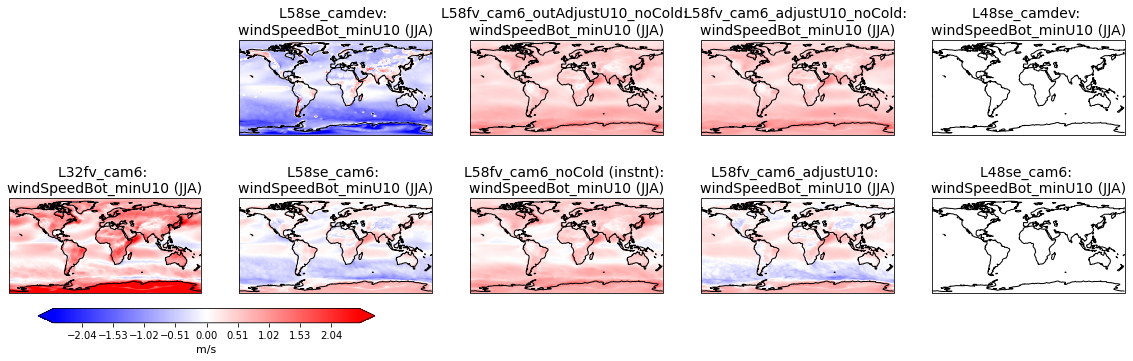

In [18]:
fileOpt = 'h1'
pltVar  = 'windSpeedBot_minU10' 
levsMap = np.arange(-2.5,2.51,0.01)

pltObs  = False
obsDS   = obs_erai
# obsDS   = obs_jra
obsName = 'WIND_MAG_SURF'

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359  

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)


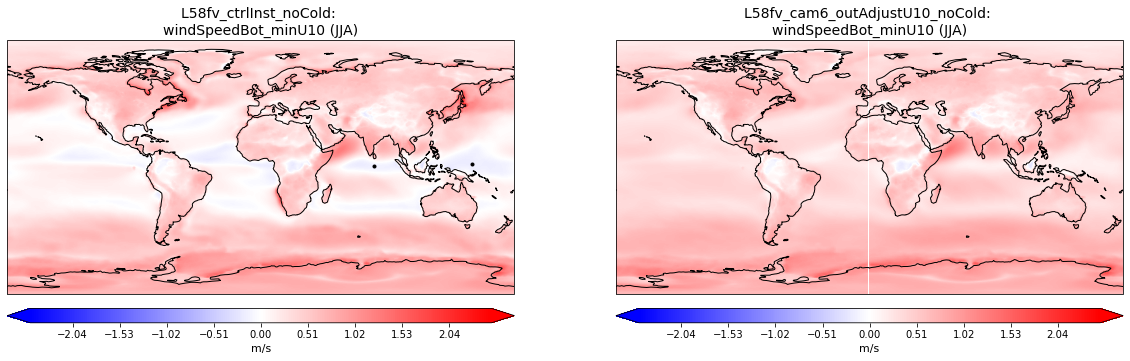

In [29]:
levsMap = np.arange(-2.5,2.51,0.01)
pltVar  = 'windSpeedBot_minU10' 

fig,axs = plt.subplots(1,2, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel() 

## L58fv_ctrlInst_noCold_h1_mean
cplot = axs[0].contourf(L58fv_ctrlInst_noCold_h1_mean.lon.values, L58fv_ctrlInst_noCold_h1_mean.lat.values,
                np.squeeze(L58fv_ctrlInst_noCold_h1_mean[pltVar].values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())
# Add coastline, set title
axs[0].coastlines()
axs[0].set_title('L58fv_ctrlInst_noCold: \n'+pltVar+' ('+selSeason+')',fontsize=14)
## Add colorbar
ax_position = axs[0].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L32fv_cam6_h1[pltVar].units,fontsize=11)

axs[0].plot(80, 1, 'ko', markersize=3, transform=ccrs.PlateCarree())
axs[0].plot(150, 2, 'ko', markersize=3, transform=ccrs.PlateCarree())



## L58fv_outAdjustU10_noCold_h1
cplot = axs[1].contourf(L58fv_outAdjustU10_noCold_h1_mean.lon.values, L58fv_outAdjustU10_noCold_h1_mean.lat.values,
                np.squeeze(L58fv_outAdjustU10_noCold_h1_mean[pltVar].values), 
                levsMap, cmap='bwr', extend='both', transform=ccrs.PlateCarree())

# Add coastline, set title
axs[1].coastlines()
axs[1].set_title('L58fv_cam6_outAdjustU10_noCold: \n'+pltVar+' ('+selSeason+')',fontsize=14)

## Add colorbar
ax_position = axs[1].get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.04])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(L32fv_cam6_h1[pltVar].units,fontsize=11)



Selected lon: 80.00
Selected lat: 1.41


Text(0.5, 1.0, 'WindSpds at point in IndOcn')

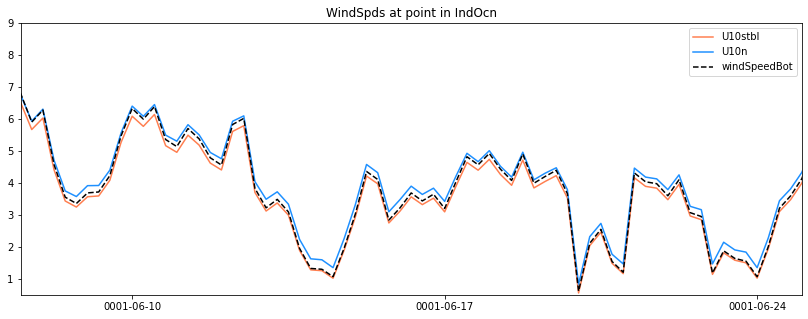

In [49]:
lonSel = 80
latSel = 1

selPoint_U10stbl = L58fv_outAdjustU10_noCold_h1.sel(lon=lonSel, lat=latSel, method='nearest') 
selPoint_U10n    = L58fv_ctrlInst_noCold_h1.sel(lon=lonSel, lat=latSel, method='nearest') 
print('Selected lon: %.2f\nSelected lat: %.2f' % (selPoint_U10stbl.lon.values, selPoint_U10stbl.lat.values) ) 

fig,axs = plt.subplots(1,1, figsize=(14,5))

axs.plot(selPoint_U10stbl.time.values, selPoint_U10stbl.U10.values, color='coral', label='U10stbl')
axs.plot(selPoint_U10n.time.values, selPoint_U10n.U10.values, color='dodgerblue', label='U10n')
axs.plot(selPoint_U10stbl.time.values, selPoint_U10stbl.windSpeedBot.values, 'k--', label='windSpeedBot')

axs.legend()

axs.set_xlim([selPoint_U10stbl.time.values[630], selPoint_U10stbl.time.values[700]])
axs.set_ylim([0.5,9])
axs.set_title('WindSpds at point in IndOcn')


Selected lon: 150.00
Selected lat: 2.36


Text(0.5, 1.0, 'WindSpds at point in WPac')

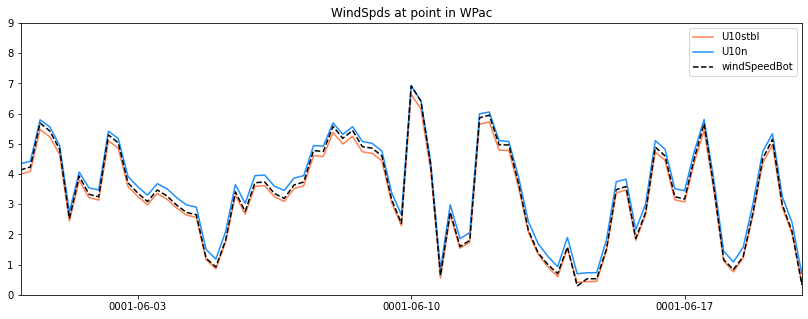

In [55]:
lonSel = 150
latSel = 2

selPoint_U10stbl = L58fv_outAdjustU10_noCold_h1.sel(lon=lonSel, lat=latSel, method='nearest') 
selPoint_U10n    = L58fv_ctrlInst_noCold_h1.sel(lon=lonSel, lat=latSel, method='nearest') 
print('Selected lon: %.2f\nSelected lat: %.2f' % (selPoint_U10stbl.lon.values, selPoint_U10stbl.lat.values) ) 

fig,axs = plt.subplots(1,1, figsize=(14,5))

axs.plot(selPoint_U10stbl.time.values, selPoint_U10stbl.U10.values, color='coral', label='U10stbl')
axs.plot(selPoint_U10n.time.values, selPoint_U10n.U10.values, color='dodgerblue', label='U10n')
axs.plot(selPoint_U10stbl.time.values, selPoint_U10stbl.windSpeedBot.values, 'k--', label='windSpeedBot')

axs.legend()

axs.set_xlim([selPoint_U10stbl.time.values[600], selPoint_U10stbl.time.values[680]])
axs.set_ylim([0,9])
axs.set_title('WindSpds at point in WPac')


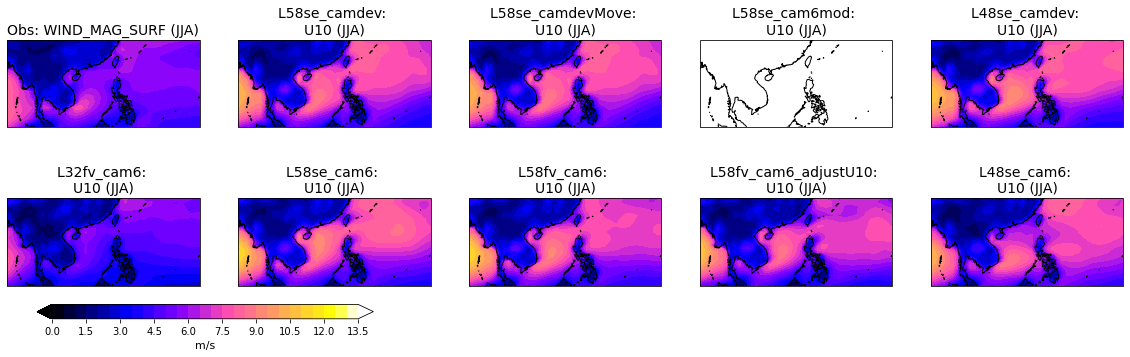

In [31]:
fileOpt = 'h1'
pltVar  = 'U10' 
levsMap = np.arange(0,14,0.5)

pltObs  = True
obsDS   = obs_erai
# obsDS   = obs_jra
obsName = 'WIND_MAG_SURF'

# Tropical NW Pacific
minLat     = 5
maxLat     = 30
minLon     = 90
maxLon     = 145  

# # Global
# minLat     = -89
# maxLat     = 89
# minLon     = 0
# maxLon     = 359  

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)



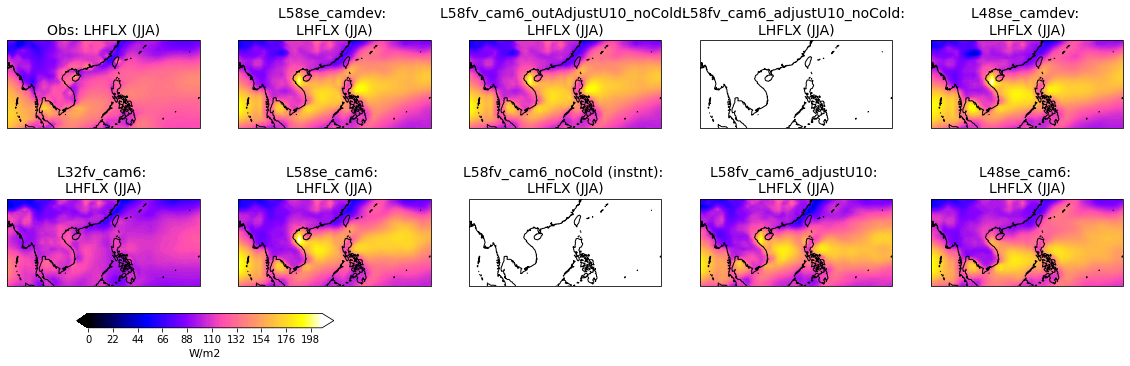

In [30]:
fileOpt = 'h1'
pltVar  = 'LHFLX' 
# levsMap = np.arange(-50,250,2)
levsMap = np.arange(0,210,2)

pltObs  = True
# obsDS   = obs_jra
obsDS   = obs_erai
obsName = 'LHFLX'

# Tropical NW Pacific
minLat     = 5
maxLat     = 30
minLon     = 90
maxLon     = 145  

# # Global
# minLat     = -89
# maxLat     = 89
# minLon     = 0
# maxLon     = 359  

# # Lab Sea region 
# minLat     = 45
# maxLat     = 70
# minLon     = (-64 % 360)
# maxLon     = ((-64+18) % 360)  

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)



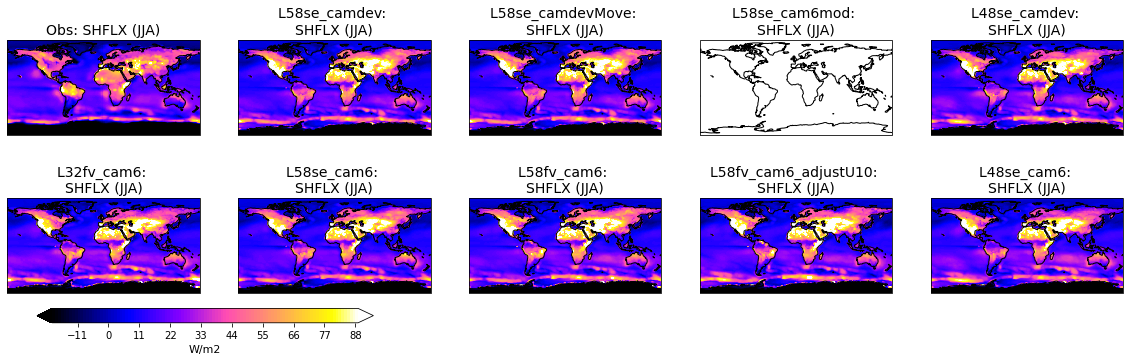

In [27]:
fileOpt = 'h1'
pltVar  = 'SHFLX' 
levsMap = np.arange(-20,90,1)

pltObs  = True
obsDS   = obs_jra
obsName = 'SHFLX'

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359 

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)



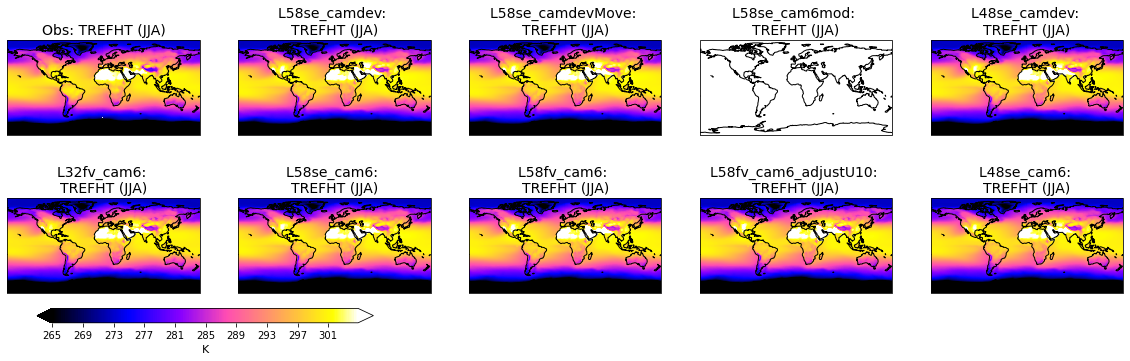

In [28]:
fileOpt = 'h1'
pltVar  = 'TREFHT' 
levsMap = np.arange(265,305,0.1)

pltObs  = True
obsDS   = obs_jra
# obsDS   = obs_erai
obsName = 'TREFHT'

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359 

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)



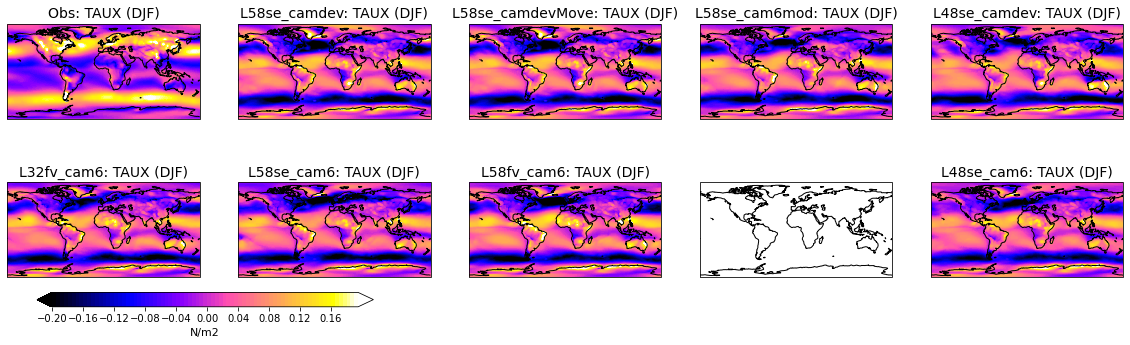

In [15]:
fileOpt = 'h0'
pltVar  = 'TAUX' 
levsMap = np.arange(-0.2, 0.2, 0.005)

pltObs  = True
obsDS   = obs_jra
obsName = 'TAUX' 

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359 

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)


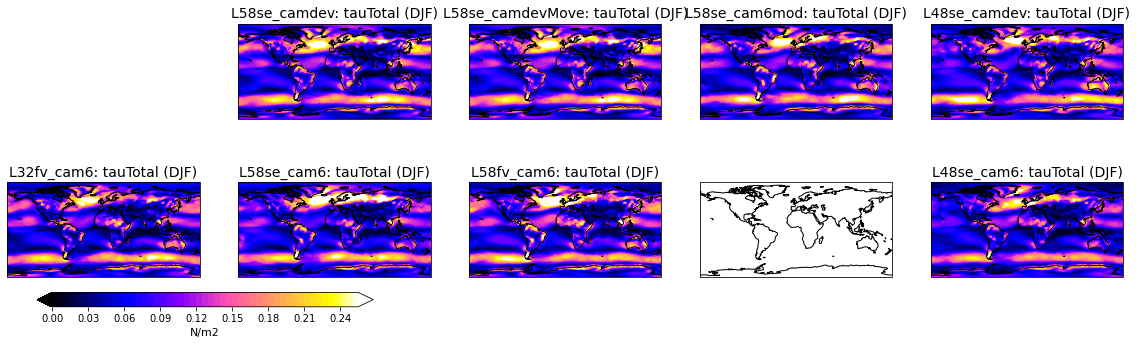

In [16]:
fileOpt = 'h0'
pltVar  = 'tauTotal' 
levsMap = np.arange(0.0, 0.26, 0.005)

pltObs  = False
obsDS   = None
obsName = None 

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359 

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)


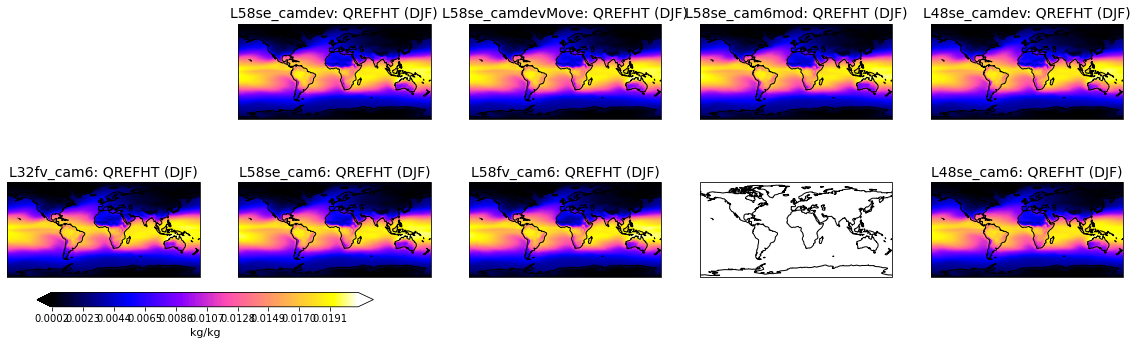

In [17]:
fileOpt = 'h1'
pltVar  = 'QREFHT' 
levsMap = np.arange(0.0002, 0.021, 0.0001)

pltObs  = False
obsDS   = None
obsName = None 

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359 

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)


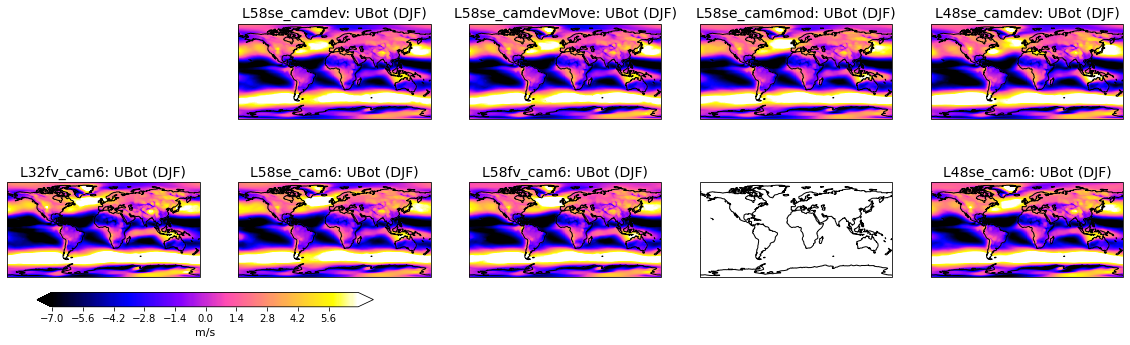

In [18]:
fileOpt = 'h1'
pltVar  = 'UBot' 
levsMap = np.arange(-7, 7, 0.05)

pltObs  = False
obsDS   = None
obsName = None 

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359 

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)


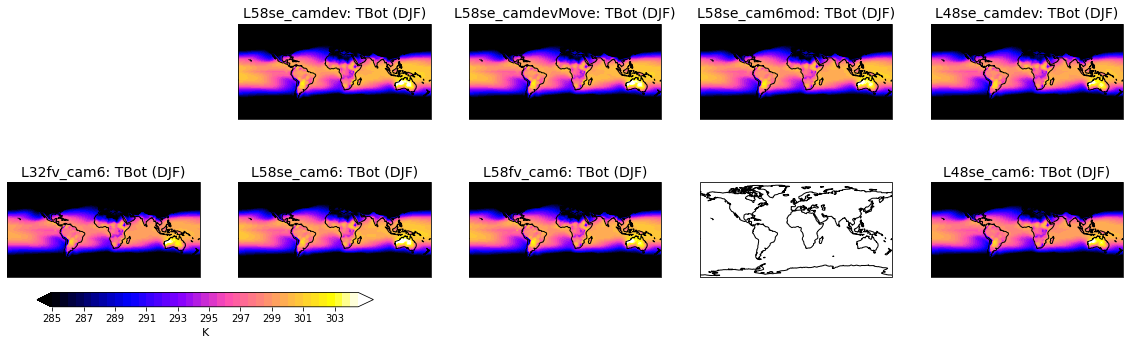

In [19]:
fileOpt = 'h1'
pltVar  = 'TBot' 
levsMap = np.arange(285,305,0.5)

pltObs  = False
obsDS   = None
obsName = None 

# # Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145  

# Global
minLat     = -89
maxLat     = 89
minLon     = 0
maxLon     = 359 

plot_rawValues(fileOpt, pltVar, levsMap, pltObs, obsDS, obsName, minLat, maxLat, minLon, maxLon)



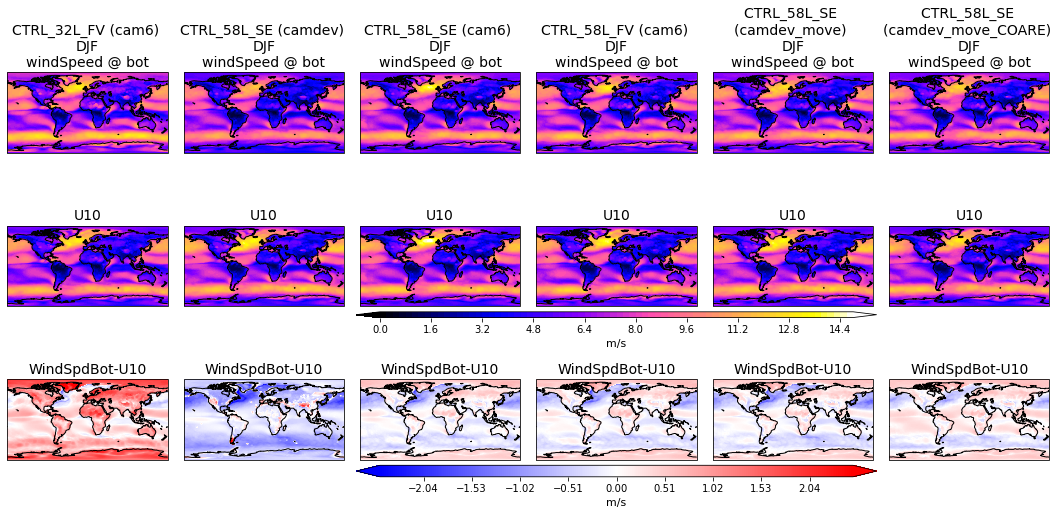

In [10]:
fig,axs = plt.subplots(3,8, figsize=(25,8), subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.2,wspace=0.1)

## levels to contour
levsMap = np.arange(0,15,0.2)

# - - - - - - - - - - - - - - 

## Plot CTRL case
contour_plot = axs[0].contourf(L32fv_cam6_h1_mean.lon.values, L32fv_cam6_h1_mean.lat.values, 
                               np.squeeze(L32fv_cam6_h1_mean['windSpeedBot'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[1].contourf(L58se_camdev_h1_mean.lon.values, L58se_camdev_h1_mean.lat.values, 
                               np.squeeze(L58se_camdev_h1_mean['windSpeedBot'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[2].contourf(L58se_cam6_h1_mean.lon.values, L58se_cam6_h1_mean.lat.values, 
                               np.squeeze(L58se_cam6_h1_mean['windSpeedBot'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[3].contourf(L58fv_cam6_h1_mean.lon.values, L58fv_cam6_h1_mean.lat.values, 
                               np.squeeze(L58fv_cam6_h1_mean['windSpeedBot'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[4].contourf(L58se_camdevMove_h1_mean.lon.values, L58se_camdevMove_h1_mean.lat.values, 
                               np.squeeze(L58se_camdevMove_h1_mean['windSpeedBot'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[5].contourf(L58se_camdevMoveCOARE_h1_mean.lon.values, L58se_camdevMoveCOARE_h1_mean.lat.values, 
                               np.squeeze(L58se_camdevMoveCOARE_h1_mean['windSpeedBot'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

# contour_plot = axs[5].contourf(L58se_cam6mod_h1_mean.lon.values, L58se_cam6mod_h1_mean.lat.values, 
#                                np.squeeze(L58se_cam6mod_h1_mean['windSpeedBot'].values), 
#                                 levsMap,
#                                 cmap='gnuplot2',extend='both',
#                                 transform=ccrs.PlateCarree())

# contour_plot = axs[6].contourf(L48se_camdev_h1_mean.lon.values, L48se_camdev_h1_mean.lat.values, 
#                                np.squeeze(L48se_camdev_h1_mean['windSpeedBot'].values), 
#                                 levsMap,
#                                 cmap='gnuplot2',extend='both',
#                                 transform=ccrs.PlateCarree())

# contour_plot = axs[7].contourf(L48se_cam6_h1_mean.lon.values, L48se_cam6_h1_mean.lat.values, 
#                                np.squeeze(L48se_cam6_h1_mean['windSpeedBot'].values), 
#                                 levsMap,
#                                 cmap='gnuplot2',extend='both',
#                                 transform=ccrs.PlateCarree())


axs[0].coastlines()
axs[0].set_title('CTRL_32L_FV (cam6) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

axs[1].coastlines()
axs[1].set_title('CTRL_58L_SE (camdev) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

axs[2].coastlines()
axs[2].set_title('CTRL_58L_SE (cam6) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

axs[3].coastlines()
axs[3].set_title('CTRL_58L_FV (cam6) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

axs[4].coastlines()
axs[4].set_title('CTRL_58L_SE \n(camdev_move) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

axs[5].coastlines()
axs[5].set_title('CTRL_58L_SE \n(camdev_move_COARE) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

# axs[5].coastlines()
# axs[5].set_title('CTRL_58L_SE (cam6mod) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

# axs[6].coastlines()
# axs[6].set_title('CTRL_48L_SE (camdev) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)

# axs[7].coastlines()
# axs[7].set_title('CTRL_48L_SE (cam6) \n'+selSeason+'\nwindSpeed @ bot',fontsize=14)


fig.delaxes(axs[6])
fig.delaxes(axs[7])

# - - - - - - - - - - - - - - 
## Plot CTRL case (U10)
contour_plot = axs[8].contourf(L32fv_cam6_h1_mean.lon.values, L32fv_cam6_h1_mean.lat.values, 
                               np.squeeze(L32fv_cam6_h1_mean['U10'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[9].contourf(L58se_camdev_h1_mean.lon.values, L58se_camdev_h1_mean.lat.values, 
                               np.squeeze(L58se_camdev_h1_mean['U10'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[10].contourf(L58se_cam6_h1_mean.lon.values, L58se_cam6_h1_mean.lat.values, 
                               np.squeeze(L58se_cam6_h1_mean['U10'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[11].contourf(L58fv_cam6_h1_mean.lon.values, L58fv_cam6_h1_mean.lat.values, 
                               np.squeeze(L58fv_cam6_h1_mean['U10'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[12].contourf(L58se_camdevMove_h1_mean.lon.values, L58se_camdevMove_h1_mean.lat.values, 
                               np.squeeze(L58se_camdevMove_h1_mean['U10'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[13].contourf(L58se_camdevMoveCOARE_h1_mean.lon.values, L58se_camdevMoveCOARE_h1_mean.lat.values, 
                               np.squeeze(L58se_camdevMoveCOARE_h1_mean['U10'].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

# contour_plot = axs[13].contourf(L58se_cam6mod_h1_mean.lon.values, L58se_cam6mod_h1_mean.lat.values, 
#                                np.squeeze(L58se_cam6mod_h1_mean['U10'].values), 
#                                 levsMap,
#                                 cmap='gnuplot2',extend='both',
#                                 transform=ccrs.PlateCarree())

# contour_plot = axs[14].contourf(L48se_camdev_h1_mean.lon.values, L48se_camdev_h1_mean.lat.values, 
#                                np.squeeze(L48se_camdev_h1_mean['U10'].values), 
#                                 levsMap,
#                                 cmap='gnuplot2',extend='both',
#                                 transform=ccrs.PlateCarree())

# contour_plot = axs[15].contourf(L48se_cam6_h1_mean.lon.values, L48se_cam6_h1_mean.lat.values, 
#                                np.squeeze(L48se_cam6_h1_mean['U10'].values), 
#                                 levsMap,
#                                 cmap='gnuplot2',extend='both',
#                                 transform=ccrs.PlateCarree())


axs[8].coastlines()
axs[8].set_title('U10',fontsize=14)

axs[9].coastlines()
axs[9].set_title('U10',fontsize=14)

axs[10].coastlines()
axs[10].set_title('U10',fontsize=14)

axs[11].coastlines()
axs[11].set_title('U10',fontsize=14)

axs[12].coastlines()
axs[12].set_title('U10',fontsize=14)

axs[13].coastlines()
axs[13].set_title('U10',fontsize=14)

# axs[14].coastlines()
# axs[14].set_title('U10',fontsize=14)

# axs[15].coastlines()
# axs[15].set_title('U10',fontsize=14)

fig.delaxes(axs[14])
fig.delaxes(axs[15])


# Add colorbar
ax_position = axs[11].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.02, ax_position.width+0.2, 0.01])
cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)



# - - - - - - - - - - - - - - 
## Plot Difference case (WindBot - U10)
levsDiff = np.arange(-2.5,2.51,0.01)

contour_plot = axs[16].contourf(L32fv_cam6_h1_mean.lon.values, L32fv_cam6_h1_mean.lat.values, 
                               np.squeeze(L32fv_cam6_h1_mean['windSpeedBot'].values -  L32fv_cam6_h1_mean['U10'].values), 
                                levsDiff,
                                cmap='bwr',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[17].contourf(L58se_camdev_h1_mean.lon.values, L58se_camdev_h1_mean.lat.values, 
                               np.squeeze(L58se_camdev_h1_mean['windSpeedBot'].values-L58se_camdev_h1_mean['U10'].values), 
                                levsDiff,
                                cmap='bwr',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[18].contourf(L58se_cam6_h1_mean.lon.values, L58se_cam6_h1_mean.lat.values, 
                               np.squeeze(L58se_cam6_h1_mean['windSpeedBot'].values-L58se_cam6_h1_mean['U10'].values), 
                                levsDiff,
                                cmap='bwr',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[19].contourf(L58fv_cam6_h1_mean.lon.values, L58fv_cam6_h1_mean.lat.values, 
                               np.squeeze(L58fv_cam6_h1_mean['windSpeedBot'].values-L58fv_cam6_h1_mean['U10'].values), 
                                levsDiff,
                                cmap='bwr',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[20].contourf(L58se_camdevMove_h1_mean.lon.values, L58se_camdevMove_h1_mean.lat.values, 
                               np.squeeze(L58se_camdevMove_h1_mean['windSpeedBot'].values-L58se_camdevMove_h1_mean['U10'].values), 
                                levsDiff,
                                cmap='bwr',extend='both',
                                transform=ccrs.PlateCarree())

contour_plot = axs[21].contourf(L58se_camdevMoveCOARE_h1_mean.lon.values, L58se_camdevMoveCOARE_h1_mean.lat.values, 
                               np.squeeze(L58se_camdevMoveCOARE_h1_mean['windSpeedBot'].values-L58se_camdevMoveCOARE_h1_mean['U10'].values), 
                                levsDiff,
                                cmap='bwr',extend='both',
                                transform=ccrs.PlateCarree())

# contour_plot = axs[21].contourf(L58se_cam6mod_h1_mean.lon.values, L58se_cam6mod_h1_mean.lat.values, 
#                                np.squeeze(L58se_cam6mod_h1_mean['windSpeedBot'].values-L58se_cam6mod_h1_mean['U10'].values), 
#                                 levsDiff,
#                                 cmap='bwr',extend='both',
#                                 transform=ccrs.PlateCarree())

# contour_plot = axs[22].contourf(L48se_camdev_h1_mean.lon.values, L48se_camdev_h1_mean.lat.values, 
#                                np.squeeze(L48se_camdev_h1_mean['windSpeedBot'].values-L48se_camdev_h1_mean['U10'].values), 
#                                 levsDiff,
#                                 cmap='bwr',extend='both',
#                                 transform=ccrs.PlateCarree())

# contour_plot = axs[23].contourf(L48se_cam6_h1_mean.lon.values, L48se_cam6_h1_mean.lat.values, 
#                                np.squeeze(L48se_cam6_h1_mean['windSpeedBot'].values-L48se_cam6_h1_mean['U10'].values), 
#                                 levsDiff,
#                                 cmap='bwr',extend='both',
#                                 transform=ccrs.PlateCarree())

axs[16].coastlines()
axs[16].set_title('WindSpdBot-U10',fontsize=14)

axs[17].coastlines()
axs[17].set_title('WindSpdBot-U10',fontsize=14)

axs[18].coastlines()
axs[18].set_title('WindSpdBot-U10',fontsize=14)

axs[19].coastlines()
axs[19].set_title('WindSpdBot-U10',fontsize=14)

axs[20].coastlines()
axs[20].set_title('WindSpdBot-U10',fontsize=14)

axs[21].coastlines()
axs[21].set_title('WindSpdBot-U10',fontsize=14)

# axs[22].coastlines()
# axs[22].set_title('WindSpdBot-U10',fontsize=14)

# axs[23].coastlines()
# axs[23].set_title('WindSpdBot-U10',fontsize=14)

fig.delaxes(axs[22])
fig.delaxes(axs[23])



# Add colorbar
ax_position = axs[19].get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)

# axs[15].plot(141.5,-56.0,'o',color='limegreen',transform=ccrs.PlateCarree())  ## scam_micre2017
# axs[15].plot(206.0,70.5,'o',color='darkorange',transform=ccrs.PlateCarree())  ## scam_mpace


### Plot biases

In [43]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [ ]:
L58fv_outAdjustU10_noCold_h1_mean

In [52]:
## Get obs grid 
obsGrid = obs_erai.WIND_MAG_SURF.isel(time=0).squeeze()

## Now regrid the data
regrid_L32fv_cam6_h1       = regrid_data(L32fv_cam6_h1_mean, obsGrid, method=1)
regrid_L58se_camdev_h1     = regrid_data(L58se_camdev_h1_mean, obsGrid, method=1)
regrid_L58fv_cam6_h1       = regrid_data(L58fv_cam6_h1_mean, obsGrid, method=1)
regrid_L58se_cam6_h1       = regrid_data(L58se_cam6_h1_mean, obsGrid, method=1)
regrid_L58se_cam6mod_h1    = regrid_data(L58se_cam6mod_h1_mean, obsGrid, method=1)
regrid_L58se_camdevMove_h1 = regrid_data(L58se_camdevMove_h1_mean, obsGrid, method=1)
regrid_L48se_camdev_h1     = regrid_data(L48se_camdev_h1_mean, obsGrid, method=1)
regrid_L48se_cam6_h1       = regrid_data(L48se_cam6_h1_mean, obsGrid, method=1)
regrid_L58se_camdevMoveCOARE_h1 = regrid_data(L58se_camdevMoveCOARE_h1_mean, obsGrid, method=1)
regrid_L58fv_adjustU10_h1       = regrid_data(L58fv_adjustU10_h1_mean, obsGrid, method=1)
regrid_L58fv_outAdjustU10_h1 = regrid_data(L58fv_outAdjustU10_noCold_h1_mean, obsGrid, method=1)

regrid_L32fv_cam6_h0       = regrid_data(L32fv_cam6_h0_mean, obsGrid, method=1)
regrid_L58se_camdev_h0     = regrid_data(L58se_camdev_h0_mean, obsGrid, method=1)
regrid_L58fv_cam6_h0       = regrid_data(L58fv_cam6_h0_mean, obsGrid, method=1)
regrid_L58se_cam6_h0       = regrid_data(L58se_cam6_h0_mean, obsGrid, method=1)
regrid_L58se_cam6mod_h0    = regrid_data(L58se_cam6mod_h0_mean, obsGrid, method=1)
regrid_L58se_camdevMove_h0 = regrid_data(L58se_camdevMove_h0_mean, obsGrid, method=1)
# regrid_L48se_camdev_h0     = regrid_data(L48se_camdev_h0_mean, obsGrid, method=1)
# regrid_L48se_cam6_h0       = regrid_data(L48se_cam6_h0_mean, obsGrid, method=1)
regrid_L58se_camdevMoveCOARE_h0 = regrid_data(L58se_camdevMoveCOARE_h0_mean, obsGrid, method=1)


In [58]:
'''
fileOpt:  h1 or h0 
pltVar:   var to map 
levsMap:  levels to use in contouring raw values 
obsDS:    DS of observations to draw from 
obsName:  Name of variable in obsDS to map
obsLabel: String to use when identifying observational product in title (i.e., 'erai')
minLat,maxLat,minLon,maxLon: Map limits 
'''

def plotBiasMaps(fileOpt, pltVar, levsMap,
                 obsDS, obsName, obsLabel,         
                 minLat, maxLat, minLon, maxLon):
    ## Set up figure 
    fig,axs = plt.subplots(2,5, figsize=(20,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.4)
    
    fig.delaxes(axs[5])

    # Plot obs in first plot 
    axs[0].contourf(obsDS.lon.values, obsDS.lat.values, np.squeeze(obsDS[obsName].values), 
                                levsMap,
                                cmap='gnuplot2',extend='both',
                                transform=ccrs.PlateCarree())

    axs[0].coastlines()
    axs[0].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[0].set_title(obsLabel+': '+obsName+' ('+selSeason+')', fontsize=14)
    
    
    if fileOpt=='h1': 
        varRegrid_L32fv_cam6   = regrid_L32fv_cam6_h1[pltVar]
        varRegrid_L58se_camdev = regrid_L58se_camdev_h1[pltVar]
        varRegrid_L58fv_cam6   = regrid_L58fv_cam6_h1[pltVar]
        varRegrid_L48se_cam6   = regrid_L48se_cam6_h1[pltVar]
        varRegrid_L58se_camdevMoveCOARE = regrid_L58se_camdevMoveCOARE_h1[pltVar]
        varRegrid_L58se_camdevMove      = regrid_L58se_camdevMove_h1[pltVar]
        varRegrid_L58fv_adjustU10       = regrid_L58fv_adjustU10_h1[pltVar]
        
    elif fileOpt=='h0':
        varRegrid_L32fv_cam6   = regrid_L32fv_cam6_h0[pltVar]
        varRegrid_L58se_camdev = regrid_L58se_camdev_h0[pltVar]
        varRegrid_L58fv_cam6   = regrid_L58fv_cam6_h0[pltVar]
        varRegrid_L48se_cam6   = regrid_L48se_cam6_h0[pltVar]
        varRegrid_L58se_camdeMoveCOARE = regrid_L58se_camdevMoveCOARE_h0[pltVar]
        varRegrid_L58se_camdeMove = regrid_L58se_camdevMove_h0[pltVar]

    else: 
        print('Please specify a valid file option: h1 or h0')
        
    ## Plot raw values in model simulations 
    axs[1].contourf(varRegrid_L32fv_cam6.lon.values, varRegrid_L32fv_cam6.lat.values, 
                    np.squeeze(varRegrid_L32fv_cam6.values), levsMap, 
                    cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
    
    axs[2].contourf(varRegrid_L58se_camdevMove.lon.values, varRegrid_L58se_camdevMove.lat.values, 
                    np.squeeze(varRegrid_L58se_camdevMove.values), levsMap, 
                    cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
    
    # cplot = axs[3].contourf(varRegrid_L58se_camdevMoveCOARE.lon.values, varRegrid_L58se_camdevMoveCOARE.lat.values, 
    #                 np.squeeze(varRegrid_L58se_camdevMoveCOARE.values), levsMap, 
    #                 cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
    
    cplot = axs[3].contourf(varRegrid_L58se_camdev.lon.values, varRegrid_L58se_camdev.lat.values, 
                    np.squeeze(varRegrid_L58se_camdev.values), levsMap, 
                    cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
    
    # Add colorbar
    ax_position = axs[3].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.04, ax_position.width+0.2, 0.02])
    cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(obsDS[obsName].units,fontsize=11)

    
    axs[4].contourf(varRegrid_L58fv_cam6.lon.values, varRegrid_L58fv_cam6.lat.values, 
                    np.squeeze(varRegrid_L58fv_cam6.values), levsMap, 
                    cmap='gnuplot2', extend='both', transform=ccrs.PlateCarree())
    
    axs[1].set_title(pltVar+'\nL32_fv_cam6')
    axs[2].set_title('L58_se_camdevMove')
    # axs[3].set_title('L58_se_camdevMoveCOARE')
    # axs[3].set_title('L58_fv_cam6_outAdjustU10_noColdOutbrk')
    axs[3].set_title('L58_se_camdev')
    axs[4].set_title('L58_fv_cam6')
    
    
    ## Plot biases 
    bias_L32fv_cam6   = np.squeeze(varRegrid_L32fv_cam6.values   - obsDS[obsName].values)
    bias_L58se_camdev = np.squeeze(varRegrid_L58se_camdev.values - obsDS[obsName].values)
    bias_L58fv_cam6   = np.squeeze(varRegrid_L58fv_cam6.values   - obsDS[obsName].values)
    bias_L48se_cam6   = np.squeeze(varRegrid_L48se_cam6.values   - obsDS[obsName].values)
    bias_L58se_camdevMove      = np.squeeze(varRegrid_L58se_camdevMove.values - obsDS[obsName].values)
    bias_L58se_camdevMoveCOARE = np.squeeze(varRegrid_L58se_camdevMoveCOARE.values - obsDS[obsName].values)
    bias_L58fv_adjustU10       = np.squeeze(varRegrid_L58fv_adjustU10.values - obsDS[obsName].values)

    maxDiff  = np.nanpercentile( [bias_L32fv_cam6, bias_L58se_camdevMove, bias_L58fv_adjustU10, bias_L58fv_cam6], 99.9) 
    minDiff  = np.nanpercentile( [bias_L32fv_cam6, bias_L58se_camdevMove, bias_L58fv_adjustU10, bias_L58fv_cam6], 0.1) 
    levEven  = np.nanmax([np.abs(maxDiff), np.abs(minDiff)])
    levsDiff = np.arange(-levEven, levEven+((2*levEven)/100), (2*levEven)/100) 
    
    axs[6].contourf(varRegrid_L32fv_cam6.lon.values, varRegrid_L32fv_cam6.lat.values, 
                    bias_L32fv_cam6, levsDiff, 
                    cmap='bwr', extend='both', transform=ccrs.PlateCarree())
    
    axs[7].contourf(varRegrid_L58se_camdevMove.lon.values, varRegrid_L58se_camdevMove.lat.values, 
                    bias_L58se_camdevMove, levsDiff, 
                    cmap='bwr', extend='both', transform=ccrs.PlateCarree())
    
    # cplot =  axs[8].contourf(varRegrid_L58se_camdevMoveCOARE.lon.values, varRegrid_L58se_camdevMoveCOARE.lat.values, 
    #                 bias_L58se_camdevMoveCOARE, levsDiff, 
    #                 cmap='bwr', extend='both', transform=ccrs.PlateCarree())
    cplot =  axs[8].contourf(varRegrid_L58fv_adjustU10.lon.values, varRegrid_L58fv_adjustU10.lat.values, 
                    bias_L58fv_adjustU10, levsDiff, 
                    cmap='bwr', extend='both', transform=ccrs.PlateCarree())
    
    # Add colorbar
    ax_position = axs[8].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.04, ax_position.width+0.2, 0.02])
    cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(obsDS[obsName].units,fontsize=11)
    
    axs[9].contourf(varRegrid_L58fv_cam6.lon.values, varRegrid_L58fv_cam6.lat.values, 
                    bias_L58fv_cam6, levsDiff, 
                    cmap='bwr', extend='both', transform=ccrs.PlateCarree())
    
    
    ## Set up other plotting options (i.e., add coasts, etc.) 
    axs[1].coastlines()
    axs[2].coastlines()
    axs[3].coastlines()
    axs[4].coastlines()
    axs[6].coastlines()
    axs[7].coastlines()
    axs[8].coastlines()
    axs[9].coastlines()
    
    axs[1].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[2].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[3].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[4].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[6].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[7].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[8].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    axs[9].set_extent([minLon,maxLon,minLat,maxLat], crs=ccrs.PlateCarree())
    
    return 

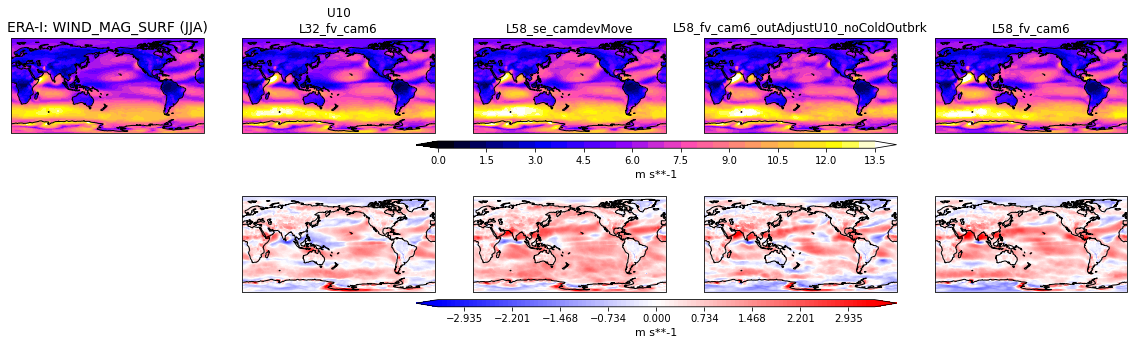

In [56]:
plotBiasMaps('h1', 'U10', np.arange(0,14,0.5),
             obs_erai, 'WIND_MAG_SURF', 'ERA-I',         
             # 5, 30, 90, 145)
             -89, 89, 0, 359)

## Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145   # Original domain

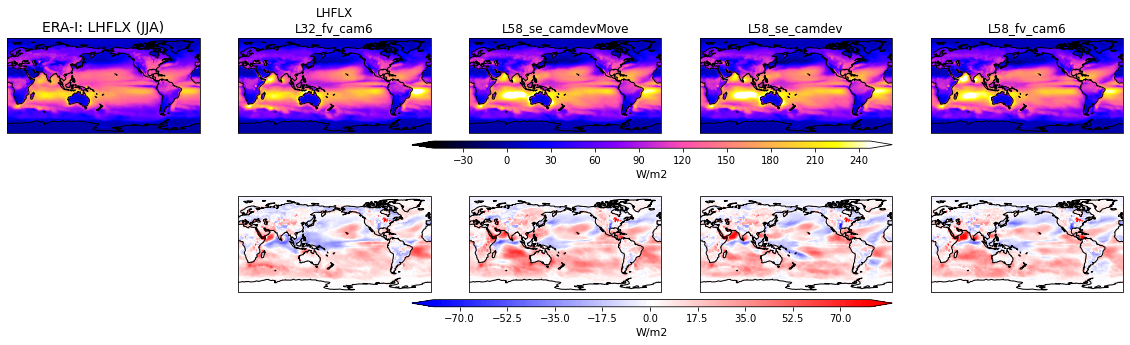

In [59]:
plotBiasMaps('h1', 'LHFLX', np.arange(-50,250,2),
             obs_erai, 'LHFLX', 'ERA-I',         
             -89, 89, 0, 359)


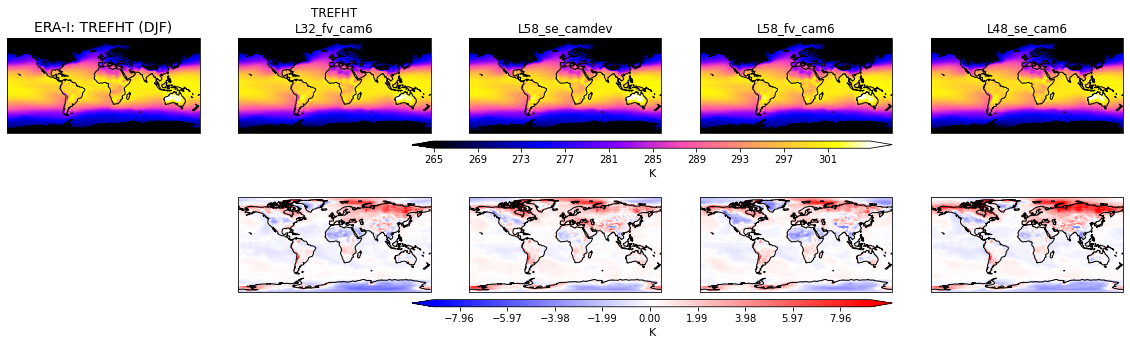

In [26]:
plotBiasMaps('h1', 'TREFHT', np.arange(265,305,0.1),
             obs_erai, 'TREFHT', 'ERA-I',         
             -89, 89, 0, 359)


In [16]:
# Define dataframe

        
def plotDist(pltVar, obsDS, obsName, obsLabel,bias=False): 
    obsVar = obsDS[obsName]
    
    L32fv_cam6_var            = regrid_L32fv_cam6_h1[pltVar]
    L58fv_cam6_var            = regrid_L58fv_cam6_h1[pltVar]
    L58se_camdev_var          = regrid_L58se_camdev_h1[pltVar]
    L58se_camdevMove_var      = regrid_L58se_camdevMove_h1[pltVar]
    L58se_camdevMoveCOARE_var = regrid_L58se_camdevMoveCOARE_h1[pltVar]
    
    if bias: 
        df = pd.concat(axis=0, ignore_index=True, objs=[
             pd.DataFrame({'Bias': np.reshape(np.squeeze(L32fv_cam6_var.values - obsVar.values), 
                               [len(L32fv_cam6_var.lat.values)*len(L32fv_cam6_var.lon.values)]),'case': 'L32_fv_cam6-obs'}),
            
            pd.DataFrame({'Bias': np.reshape(np.squeeze(L58fv_cam6_var.values - obsVar.values), 
                               [len(L58fv_cam6_var.lat.values)*len(L58fv_cam6_var.lon.values)]),'case': 'L58_fv_cam6-obs'}),
            
            # pd.DataFrame({'Bias': np.reshape(np.squeeze(L58se_camdev_var.values - obsVar.values), 
            #                    [len(L32fv_cam6_var.lat.values)*len(L32fv_cam6_var.lon.values)]),'case': 'L58_se_camdev-obs'}),
            
            pd.DataFrame({'Bias': np.reshape(np.squeeze(L58se_camdevMove_var.values - obsVar.values), 
                               [len(L58se_camdevMove_var.lat.values)*len(L58se_camdevMove_var.lon.values)]),'case': 'L58_se_camdevMove-obs'}),
        
            pd.DataFrame({'Bias': np.reshape(np.squeeze(L58se_camdevMoveCOARE_var.values - obsVar.values), 
                               [len(L58se_camdevMoveCOARE_var.lat.values)*len(L58se_camdevMoveCOARE_var.lon.values)]),'case': 'L58_se_camdevMoveCOARE-obs'}),
             
            ])
        
        # Make plot 
        g = sns.displot(df, x='Bias', hue='case', kind='kde', height=8, cut=0, 
                palette=['limegreen','dodgerblue','mediumorchid','darkorange'])
        g.ax.axvline(0,color='grey')
        

        g.ax.set_title(pltVar+' Bias ('+selSeason+'; CAM - '+obsLabel+')', fontsize=16)
        g.ax.set_xlabel('Bias', fontsize=14)
        g.ax.tick_params(axis='both', labelsize= 12)
        plt.setp(g._legend.get_title(), fontsize=12)
        plt.setp(g._legend.get_texts(), fontsize=12)

        plt.show()
    
    else: 
        df = pd.concat(axis=0, ignore_index=True, objs=[
            pd.DataFrame({pltVar: np.reshape(np.squeeze(obsVar.values), 
                               [len(obsVar.lat.values)*len(obsVar.lon.values)]),'case': obsLabel}),
            
            pd.DataFrame({pltVar: np.reshape(np.squeeze(L32fv_cam6_var.values), 
                               [len(L32fv_cam6_var.lat.values)*len(L32fv_cam6_var.lon.values)]),'case': 'L32_fv_cam6'}),
            
            pd.DataFrame({pltVar: np.reshape(np.squeeze(L58fv_cam6_var.values), 
                               [len(L58fv_cam6_var.lat.values)*len(L58fv_cam6_var.lon.values)]),'case': 'L58_fv_cam6'}),
            
#             pd.DataFrame({pltVar: np.reshape(np.squeeze(L58se_camdev_var.values), 
#                                [len(L32fv_cam6_var.lat.values)*len(L32fv_cam6_var.lon.values)]),'case': 'L58_se_camdev'}),
            
            pd.DataFrame({pltVar: np.reshape(np.squeeze(L58se_camdevMove_var.values), 
                               [len(L58se_camdevMove_var.lat.values)*len(L58se_camdevMove_var.lon.values)]),'case': 'L58_se_camdevMove'}),
        
            pd.DataFrame({pltVar: np.reshape(np.squeeze(L58se_camdevMoveCOARE_var.values), 
                               [len(L58se_camdevMoveCOARE_var.lat.values)*len(L58se_camdevMoveCOARE_var.lon.values)]),'case': 'L58_se_camdevMoveCOARE'}),
             
            ])

        # Make plot 
        g = sns.displot(df, x=pltVar, hue='case', kind='kde', height=8, cut=0, 
                palette=['k','limegreen','dodgerblue','mediumorchid','darkorange'])
        g.ax.axvline(0,color='grey')
        

        g.ax.set_title(pltVar+' ('+selSeason+')', fontsize=16)
        g.ax.set_xlabel(pltVar, fontsize=14)
        g.ax.tick_params(axis='both', labelsize= 12)
        plt.setp(g._legend.get_title(), fontsize=12)
        plt.setp(g._legend.get_texts(), fontsize=12)

        plt.show()
    
    return





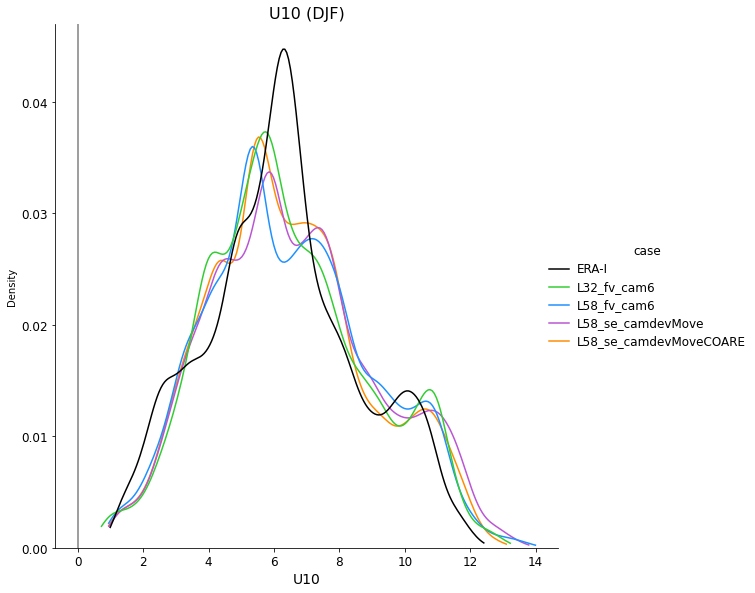

In [17]:
plotDist('U10', obs_erai, 'WIND_MAG_SURF', 'ERA-I',bias=False)


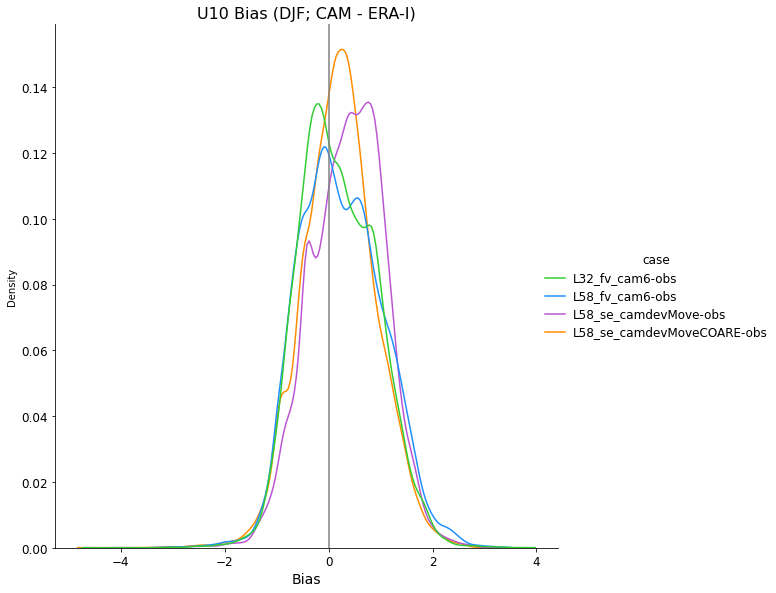

In [18]:
plotDist('U10', obs_erai, 'WIND_MAG_SURF', 'ERA-I',bias=True)


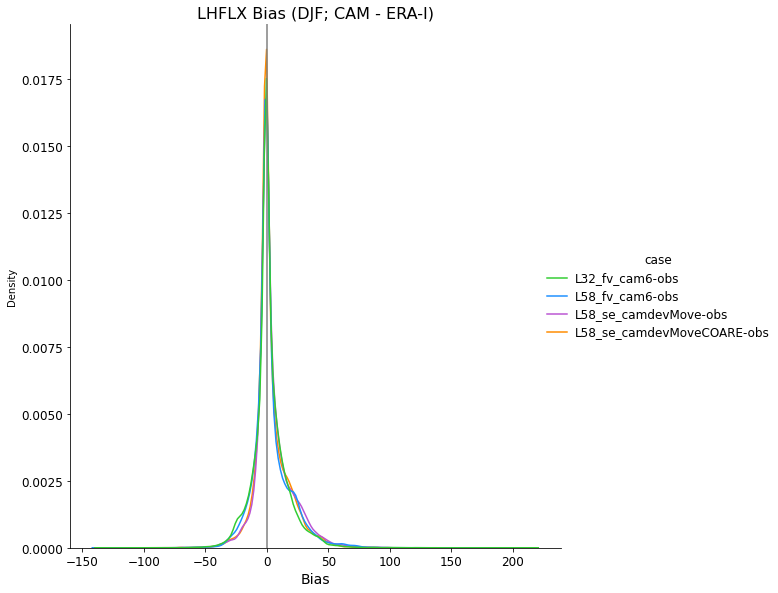

In [19]:
plotDist('LHFLX', obs_erai, 'LHFLX', 'ERA-I',bias=True)


**Look at difference between two cases?**

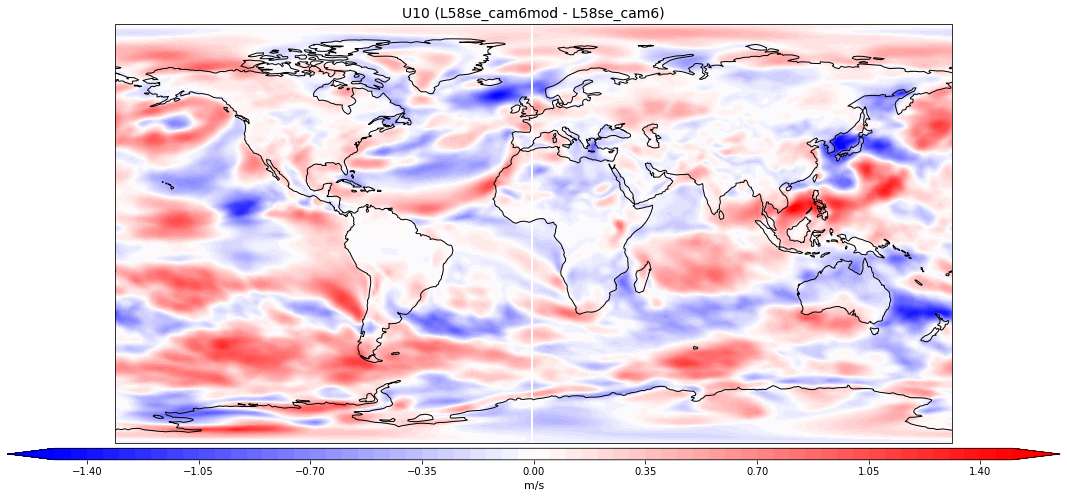

In [39]:
# caseCtrl : L58se_cam6_h1_mean
# caseTest : L58se_cam6mod_h1_mean

varPlot = 'U10'
levsMap = np.arange(-1.5,1.55,0.05)

fig,axs = plt.subplots(1,1, figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(L58se_cam6_h1_mean.lon.values, L58se_cam6_h1_mean.lat.values, 
                     np.squeeze(L58se_cam6mod_h1_mean[varPlot].values - L58se_cam6_h1_mean[varPlot].values), 
                     levsMap, cmap = 'bwr', extend='both',transform=ccrs.PlateCarree() )

axs.coastlines()
axs.set_title(varPlot+' (L58se_cam6mod - L58se_cam6)',fontsize=14)


# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)




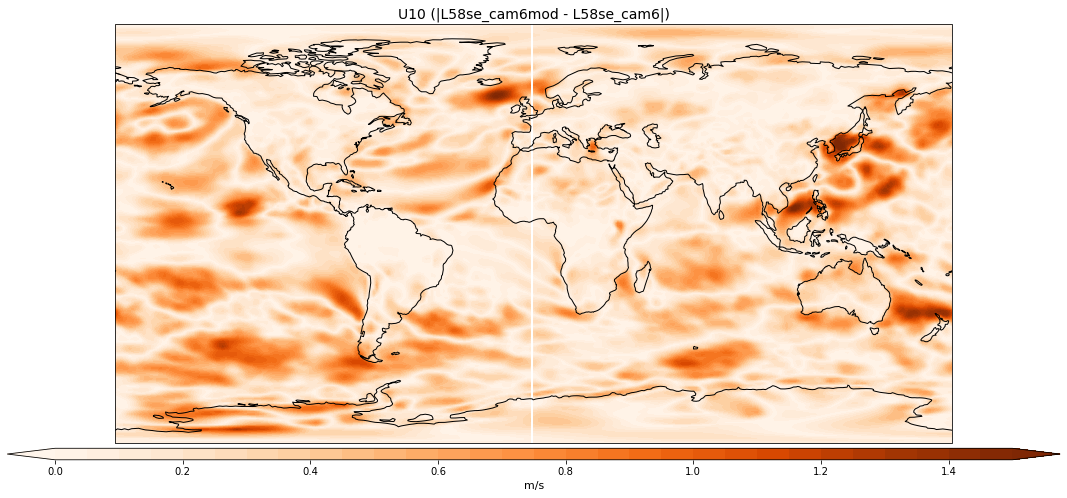

In [40]:
# caseCtrl : L58se_cam6_h1_mean
# caseTest : L58se_cam6mod_h1_mean

varPlot = 'U10'
levsMap = np.arange(0,1.55,0.05)

fig,axs = plt.subplots(1,1, figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree()})

cplot = axs.contourf(L58se_cam6_h1_mean.lon.values, L58se_cam6_h1_mean.lat.values, 
                     np.abs(np.squeeze(L58se_cam6mod_h1_mean[varPlot].values - L58se_cam6_h1_mean[varPlot].values)), 
                     levsMap, cmap = 'Oranges', extend='both',transform=ccrs.PlateCarree() )

axs.coastlines()
axs.set_title(varPlot+' (|L58se_cam6mod - L58se_cam6|)',fontsize=14)


# Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('m/s',fontsize=11)


